In [1]:
import numpy as np

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as sc
from scipy.cluster.hierarchy import linkage, cut_tree, leaves_list

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

import os

import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, Activation
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers

In [2]:
def elapsedtime_to_sec(el):
    tab = el.split(":")
    return float(tab[0])*60+float(tab[1])
#because x264 output is "m:s", where m is the number of minutes and s the number of seconds 

res_dir = "../../data/res_ugc/"

v_names = sorted(os.listdir(res_dir)) # so we keep the same ids between two launches

listVideo = []

for v in v_names:
    data = pd.read_table(res_dir+v, delimiter = ',')
    data['etime'] = [*map(elapsedtime_to_sec, data['elapsedtime'])]
    assert data.shape == (201,34), v
    listVideo.append(data)

input_sizes = pd.read_csv("../../data/sizes.csv", delimiter=',').set_index('name')
#input_sizes.columns = ['path','name','size']
input_sizes

for i in range(len(listVideo)):
    input_video_size = input_sizes.loc[v_names[i][:-4]]['size']
    listVideo[i]['crate'] = listVideo[i]['size']/input_video_size

In [3]:
len(listVideo)

1397

In [4]:
totalTime = np.sum([np.sum(vid["etime"]) for vid in listVideo])
print("Hours : "+str(totalTime/(3600)))
print("Days : "+str(totalTime/(24*3600)))

Hours : 810.7560972222223
Days : 33.781504050925925


In [5]:
#our variable of interest
predDimension = "size"

for i in range(len(listVideo)):
    sizes = listVideo[i][predDimension]
    ind = sorted(range(len(sizes)), key=lambda k: sizes[k])
    listVideo[i]['ranking'] = ind

# Introduction

In [6]:
ratio_placebo_ultrafast = []
for j in range(len(listVideo)):
    ratio_placebo_ultrafast.append(listVideo[j].loc[0][predDimension]/listVideo[j].loc[10][predDimension])
print(np.mean(ratio_placebo_ultrafast))

1.9596497685729535


In [7]:
listVideo[0]

,configurationID,cabac,ref,deblock,analyse,me,subme,mixed_ref,me_range,trellis,...,usertime,systemtime,elapsedtime,cpu,frames,fps,kbs,etime,crate,ranking
0,1,0,1,0:0:0,0:0,dia,0,0,16,0,...,7.94,1.36,0:02.14,434,600,375.22,161.07,2.14,0.000216,166
1,101,1,2,1:0:0,0x3:0x113,hex,6,1,16,1,...,23.17,1.79,0:03.40,734,600,217.07,93.57,3.40,0.000125,164
2,102,1,2,1:0:0,0x3:0x113,hex,6,1,16,1,...,18.42,1.66,0:02.71,739,600,293.42,63.87,2.71,0.000086,169
3,103,1,2,0:0:0,0x3:0x3,umh,6,1,16,1,...,22.39,1.53,0:02.78,858,600,276.79,65.37,2.78,0.000088,165
4,104,1,16,1:0:0,0x3:0x113,hex,6,1,24,1,...,17.40,1.76,0:02.74,699,600,287.79,87.27,2.74,0.000117,168
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,97,1,2,1:0:0,0x3:0x113,hex,4,1,16,0,...,19.26,2.34,0:03.01,716,600,254.20,73.20,3.01,0.000098,7
197,98,1,2,0:0:0,0x3:0x113,hex,4,0,24,0,...,16.79,1.77,0:02.88,644,600,269.38,78.21,2.88,0.000105,148
198,99,1,5,1:0:0,0x3:0x113,hex,6,1,16,1,...,25.74,1.40,0:02.92,927,600,263.64,71.19,2.92,0.000095,147
199,100,0,3,0:0:0,0x113:0x113,hex,6,1,16,1,...,18.11,1.74,0:02.89,685,600,267.21,93.51,2.89,0.000125,188


In [8]:
np.mean(listVideo[np.argmax([np.mean(vid["etime"]) for vid in listVideo])]["etime"])
#v_names[np.argmax([np.mean(vid["etime"]) for vid in listVideo])]

188.70930348258707

# RQ1 - Input sensitivity

## RQ1.1 - Do the same options have the same effect on all inputs?

In [9]:
nbVideos = len(listVideo)
corrSpearman = [[0 for x in range(nbVideos)] for y in range(nbVideos)]

for i in range(nbVideos):
    for j in range(nbVideos):
        if (i == j):
            corrSpearman[i][j] = 1
        else:
            corrSpearman[i][j] = sc.spearmanr(listVideo[i][predDimension],
                                            listVideo[j][predDimension]).correlation

In [10]:
min_val = 1
ind_i = 0
ind_j = 0
for i in range(len(corrSpearman)):
    for j in range(len(corrSpearman[0])):
        if corrSpearman[i][j] < min_val:
            min_val = corrSpearman[i][j]
            ind_i = i
            ind_j = j

print("Value : ", min_val)
print("i : ", ind_i, ", j : ", ind_j)

Value :  -0.6938364419242731
i :  9 , j :  1166


In [11]:
corrSpearman[57][1192]

0.4635936732198079

In [12]:
corrSpearman[689][1192]

0.26545041275184017

In [13]:
corrSpearman[57][689]

0.8149430902074406

In [14]:
argm = [np.max([k for k in corrSpearman[i] if k <1]) for i in range(len(corrSpearman))]
pd.Series(argm).describe()

count    1397.000000
mean        0.969512
std         0.022921
min         0.803562
25%         0.963100
50%         0.975897
75%         0.983899
max         0.997228
dtype: float64

In [15]:
np.percentile(argm, 5)

0.9216475343513424

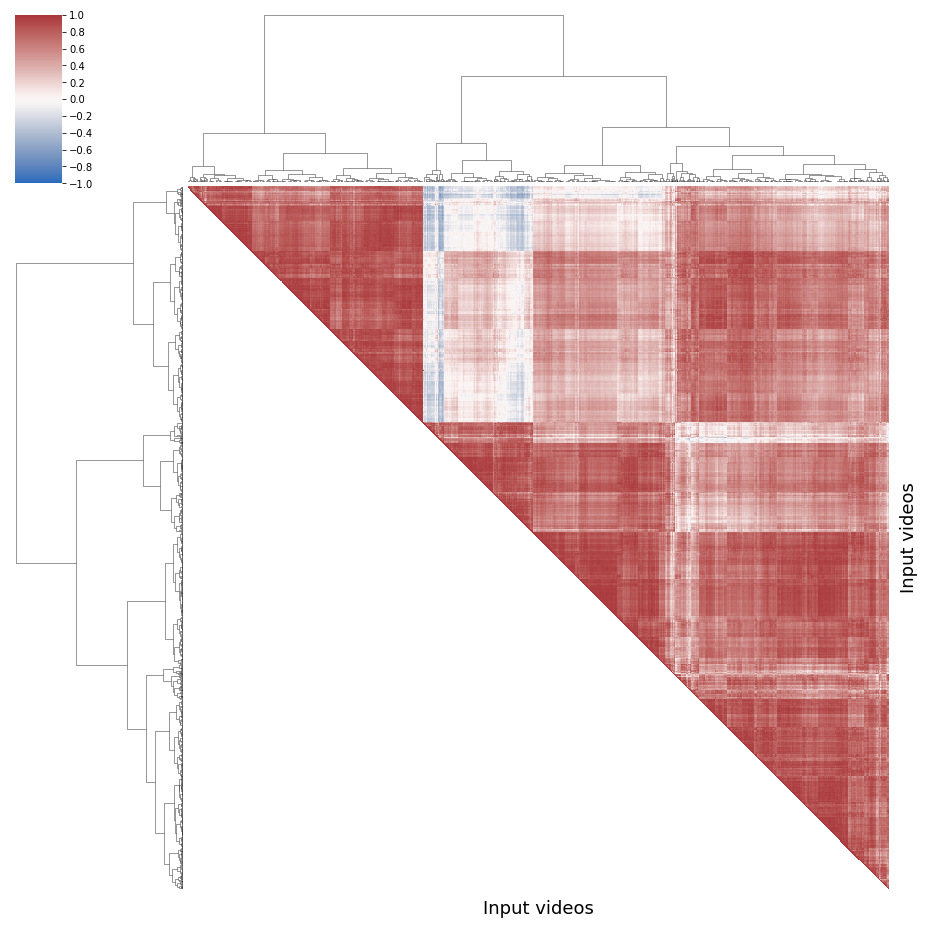

In [16]:
result_dir = "../../results/"

def plot_correlationmatrix_dendogram(corr, img_name, ticks, method= 'ward', div=False):

    df = pd.DataFrame(corr)
    
    # group the videos
    links = linkage(df, method=method,)
    order = leaves_list(links)
    
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    
    for i in range(nbVideos):
        for j in range(nbVideos):
            if i>j:
                mask[order[i]][order[j]] = True
    
    g = sns.clustermap(df, cmap="vlag", mask=mask, method=method,
                   linewidths=0, figsize=(13, 13), cbar_kws={"ticks":ticks}, vmin =-1)
    g.ax_heatmap.set_yticklabels([])
    g.ax_heatmap.set_xticklabels([])
    g.ax_heatmap.tick_params(right=False, bottom=False)
    g.ax_heatmap.set_xlabel("Input videos", fontsize = 18)
    g.ax_heatmap.set_ylabel("Input videos", fontsize = 18)
    plt.savefig(result_dir+img_name)
    plt.show()
    
    return cut_tree(links, n_clusters = 4)

group_no_ordered = plot_correlationmatrix_dendogram(corrSpearman, 
                                 "corrmatrix-ugc-dendo-Spearman-" + predDimension + ".pdf",
                                 [k/5 for k in np.arange(-10,10,1)], method='ward')

In [17]:
map_group = [0, 1, 2, 3]

def f(gr):
    return map_group[int(gr)]

groups = np.array([*map(f, group_no_ordered)],int)

print(sum(groups==0))
print(sum(groups==1))
print(sum(groups==2))
print(sum(groups==3))

262
470
446
219


In [18]:
corrDescription = [corrSpearman[i][j] for i in range(nbVideos) for j in range(nbVideos) if i >j]
pd.Series(corrDescription).describe()

count    975106.000000
mean          0.566601
std           0.288890
min          -0.693836
25%           0.394660
50%           0.630341
75%           0.794691
max           0.997228
dtype: float64

In [19]:
def plot_simple_correlationmatrix_dendogram(corr, img_name, ticks, id_names, method='ward'):

    df = pd.DataFrame(corr)
    
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    
    for i in range(shortnbVideos):
        for j in range(shortnbVideos):
            if i>j:
                mask[i][j] = True
    fig = plt.figure(figsize=(10, 8.5))
    ax = fig.add_subplot(1,1,1)
    sns.heatmap(df, cmap="vlag", mask=mask,
               linewidths=.75, cbar_kws={"ticks":ticks})
    plt.yticks(np.arange(0,len(id_names),1)+0.5, id_names)
    plt.xticks(np.arange(0,len(id_names),1)+0.5, id_names)
    plt.savefig(result_dir+img_name)
    plt.show()

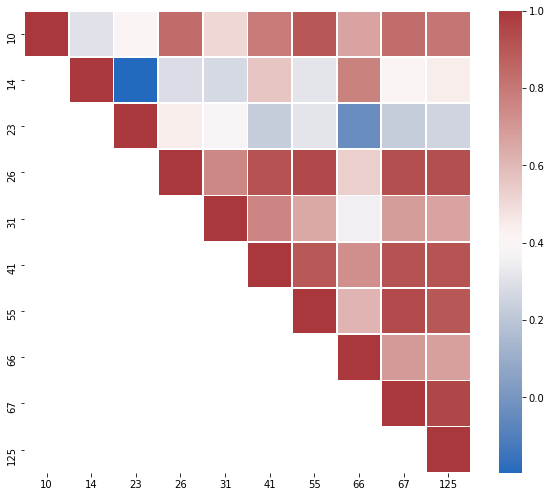

In [20]:
id_short = [10, 14, 23, 26, 31, 41, 55, 66, 67, 125]
short_v_names = [v_names[k] for k in id_short]

shortlistVideo = []
for v in short_v_names:
    data = pd.read_table(res_dir+v, delimiter = ',')
    data['etime'] = [*map(elapsedtime_to_sec, data['elapsedtime'])]
    input_video_size = input_sizes.loc[v[:-4]]['size']
    data['crate'] = data['size']/input_video_size
    shortlistVideo.append(data)
    
shortnbVideos = len(shortlistVideo)

shortcorrSpearman= [[0 for x in range(shortnbVideos)] for y in range(shortnbVideos)]


for i in range(shortnbVideos):
    for j in range(shortnbVideos):
        if (i == j):
            shortcorrSpearman[i][j] = 1
        else:
            shortcorrSpearman[i][j] = sc.spearmanr(listVideo[id_short[i]][predDimension],listVideo[id_short[j]][predDimension]).correlation

plot_simple_correlationmatrix_dendogram(shortcorrSpearman, 
                     "../../results/corrmatrix-ugc-dendo-Spearman-short-" + predDimension + ".png", 
                     [k/5 for k in np.arange(-10,10,1)],
                                      id_short)

# RQ1-2

### Shortlist

In [21]:
id_short

[10, 14, 23, 26, 31, 41, 55, 66, 67, 125]

In [22]:
shortlistVideo[0] # video 10

,configurationID,cabac,ref,deblock,analyse,me,subme,mixed_ref,me_range,trellis,...,size,usertime,systemtime,elapsedtime,cpu,frames,fps,kbs,etime,crate
0,1,0,1,0:0:0,0:0,dia,0,0,16,0,...,19188344,8.69,0.92,0:01.75,549,480,379.18,7675.34,1.75,0.012852
1,101,1,2,1:0:0,0x3:0x113,hex,6,1,16,1,...,6805614,29.88,1.56,0:04.08,770,480,137.35,2722.25,4.08,0.004558
2,102,1,2,1:0:0,0x3:0x113,hex,6,1,16,1,...,7948383,26.00,1.58,0:03.04,905,480,194.98,3179.35,3.04,0.005324
3,103,1,2,0:0:0,0x3:0x3,umh,6,1,16,1,...,7857313,32.80,1.37,0:02.89,1181,480,206.63,3142.93,2.89,0.005263
4,104,1,16,1:0:0,0x3:0x113,hex,6,1,24,1,...,6448461,39.70,1.41,0:03.29,1249,480,176.69,2579.38,3.29,0.004319
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,97,1,2,1:0:0,0x3:0x113,hex,4,1,16,0,...,6868554,24.80,1.67,0:03.55,745,480,160.70,2747.42,3.55,0.004600
197,98,1,2,0:0:0,0x3:0x113,hex,4,0,24,0,...,7014505,21.85,1.59,0:03.06,766,480,192.69,2805.80,3.06,0.004698
198,99,1,5,1:0:0,0x3:0x113,hex,6,1,16,1,...,6455932,32.95,1.42,0:03.45,996,480,166.61,2582.37,3.45,0.004324
199,100,0,3,0:0:0,0x113:0x113,hex,6,1,16,1,...,8448726,26.68,1.56,0:02.76,1022,480,218.91,3379.49,2.76,0.005659


In [23]:
listFeatures = ["cabac", "ref", "deblock", "analyse", "me", "subme", "mixed_ref", "me_range", "trellis", "8x8dct", "fast_pskip", "chroma_qp_offset", "bframes", "b_pyramid", "b_adapt", "direct", "weightb", "open_gop", "weightp", "scenecut", "rc_lookahead", "mbtree", "qpmax", "aq-mode"]

to_keep = [k for k in listFeatures]
to_keep.append(predDimension)

categorial = ['analyse', 'me', 'direct']

def compute_Importances(listVid, id_short=None):
    
    if not id_short:
        id_short = np.arange(0,len(listVid),1)
        
    listImportances = []

    for id_video in range(len(listVid)):

        df = listVid[id_video][to_keep].replace(to_replace ="None",value='0')

        df['deblock'] =[int(val[0]) for val in df['deblock']]

        for col in df.columns:
            if col not in categorial:
                arr_col = np.array(df[col],int)
                arr_col = (arr_col-np.mean(arr_col))/(np.std(arr_col)+1e-5)
                df[col] = arr_col
            else:
                if col not in [predDimension,'ranking']:
                    df[col] = [np.where(k==df[col].unique())[0][0] for k in df[col]]
                    arr_col = np.array(df[col],int)
                    arr_col = (arr_col-np.mean(arr_col))/(np.std(arr_col)+1e-5)
                    df[col] = arr_col

        clf = RandomForestRegressor(n_estimators=200)
        X = df.drop([predDimension],axis=1)
        y = df[predDimension]
        clf.fit(X,y)

        listImportances.append(clf.feature_importances_)

    res = pd.DataFrame({'features' : listFeatures})

    cs = 100

    for id_video in range(len(listImportances)):
        res['video_'+str(id_short[id_video])] = np.round(cs*listImportances[id_video])/cs

    res = res.set_index('features').transpose().drop(['open_gop','qpmax'],axis=1)
    return res

res = compute_Importances(listVideo)
res.to_csv("../../results/list_features_importances"+predDimension+".csv")

### Boxplot

In [24]:
res_imp = compute_Importances(listVideo)

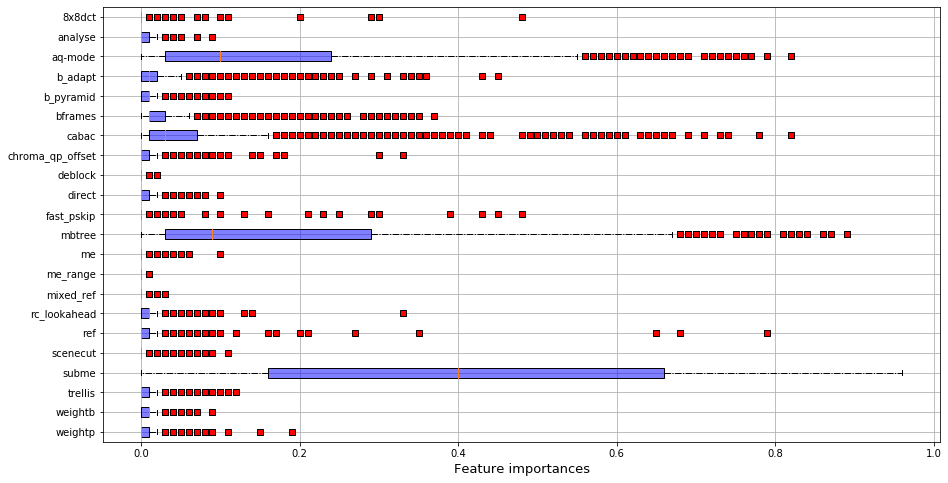

In [25]:
def boxplot_imp(res, xlim = None, criteria = 'max', name = None, xname='Feature importances'):
    if criteria == 'max':
        listImp = [(np.percentile(res[col],75), res[col], col) 
                   for col in res.columns]
        listImp.sort(key=lambda tup: tup[0])
    elif criteria == 'range':
        listImp = [(np.abs(np.percentile(res[col],75)-np.percentile(res[col],25)),res[col], col) 
                   for col in res.columns]
        listImp.sort(key=lambda tup: tup[0])
    elif criteria == 'name':
        listImp = [(np.abs(np.percentile(res[col],75)-np.percentile(res[col],25)),res[col], col) 
                   for col in res.columns]
        listImp.sort(key=lambda tup: tup[2], reverse=True)

    red_square = dict(markerfacecolor='r', marker='s')
    plt.figure(figsize=(15,8))
    plt.grid()
    plt.boxplot([l[1] for l in listImp], flierprops=red_square, 
              vert=False, patch_artist=True, #widths=0.25,
              boxprops=dict(facecolor=(0,0,1,0.5),linewidth=1,edgecolor='k'),
              whiskerprops = dict(linestyle='-.',linewidth=1.0, color='black'))
    plt.xlabel(xname, size=13)
    if xlim:
        plt.xlim(xlim)
    plt.yticks(range(1, len(listImp) + 1), [l[2] for l in listImp])
    if name:
        plt.savefig(name)
    plt.show()
    
boxplot_imp(res_imp,
            criteria = 'name', 
            name = "../../results/boxplot_features_imp_rf_"+predDimension+".png")

### Regression

In [26]:
def compute_poly(listVid, id_short=None):
    
    if not id_short:
        id_short = np.arange(0,len(listVid),1)
    
    listImportances = []
    
    #listFeatures = ['subme','aq-mode','mbtree','cabac']
    
    to_keep = [k for k in listFeatures]
    to_keep.append(predDimension)
    
    names = listFeatures
    final_names = []
    final_names.append('constant')
    for n in names:
        final_names.append(n)
    for n1 in range(len(names)):
        for n2 in range(len(names)):
            if n1>=n2:
                final_names.append(str(names[n1])+'*'+str(names[n2]))
    
    for id_video in range(len(listVid)):

        df = listVid[id_video][to_keep].replace(to_replace ="None",value='0')
        df['deblock'] =[int(val[0]) for val in df['deblock']]

        for col in df.columns:
            if col not in categorial:
                arr_col = np.array(df[col],int)
                arr_col = (arr_col-np.mean(arr_col))/(np.std(arr_col)+1e-5)
                df[col] = arr_col
            else:
                df[col] = [np.where(k==df[col].unique())[0][0] for k in df[col]]
                arr_col = np.array(df[col],int)
                arr_col = (arr_col-np.mean(arr_col))/(np.std(arr_col)+1e-5)
                df[col] = arr_col

        clf = LinearRegression()
        X = df.drop([predDimension],axis=1)

        y = df[predDimension]
        #poly = PolynomialFeatures(degree=1, interaction_only = False, include_bias = True)    
        #X_interact = pd.DataFrame(poly.fit_transform(X))#, columns=final_names)
        #kept_names = ['subme','aq-mode','mbtree','cabac','cabac*mbtree','aq-mode*subme','cabac*subme']
        clf.fit(X,y)
        listImportances.append(clf.coef_)

    res = pd.DataFrame({'features' : listFeatures})

    cs = 100

    for id_video in range(len(listImportances)):
        res['video_'+str(id_short[id_video])] = np.round(cs*listImportances[id_video])/cs

    res = res.set_index('features').drop(['open_gop','qpmax']).transpose()
    return res

res_coef = compute_poly(listVideo)
res_coef.to_csv("../../results/list_features_importances_poly_"+predDimension+".csv")
res_coef

features,cabac,ref,deblock,analyse,me,subme,mixed_ref,me_range,trellis,8x8dct,...,bframes,b_pyramid,b_adapt,direct,weightb,weightp,scenecut,rc_lookahead,mbtree,aq-mode
video_0,-0.18,-0.00,0.06,-0.07,-0.07,-0.03,-0.03,-0.06,-0.09,-0.01,...,-0.05,0.16,0.05,-0.02,-0.18,-0.13,-0.15,-0.01,-0.05,0.00
video_1,-0.25,-0.15,-0.04,-0.04,-0.17,-0.28,0.00,-0.04,0.04,-0.19,...,-0.09,0.07,0.04,-0.01,-0.14,-0.06,0.03,-0.01,0.13,-0.43
video_2,-0.19,0.00,-0.05,-0.03,-0.07,-0.30,-0.05,-0.03,0.03,-0.11,...,-0.07,-0.09,0.06,-0.02,-0.34,0.04,-0.04,0.05,-0.02,-0.27
video_3,-0.15,0.07,-0.09,-0.04,-0.06,-0.32,-0.01,-0.05,0.11,-0.17,...,-0.06,-0.17,0.12,-0.01,-0.33,0.03,-0.01,0.05,0.27,-0.43
video_4,-0.14,0.02,-0.05,-0.00,-0.10,-0.26,-0.01,-0.04,0.06,-0.20,...,-0.10,-0.00,0.13,-0.04,-0.33,0.01,0.01,0.03,0.11,-0.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
video_1392,-0.16,0.05,-0.09,-0.05,-0.06,-0.33,-0.01,-0.06,0.05,-0.20,...,-0.04,-0.06,0.19,-0.02,-0.36,0.06,-0.04,0.11,-0.13,-0.29
video_1393,-0.06,0.11,-0.13,-0.08,-0.05,-0.37,-0.02,-0.06,0.11,-0.21,...,-0.08,-0.05,0.08,-0.00,-0.33,0.03,0.00,0.06,0.42,-0.47
video_1394,-0.14,0.07,-0.12,-0.06,-0.06,-0.41,-0.01,-0.06,0.10,-0.21,...,-0.07,-0.08,0.16,0.00,-0.31,0.02,0.00,0.05,0.09,-0.35
video_1395,-0.44,0.01,-0.07,-0.05,-0.10,-0.12,-0.00,-0.02,0.10,-0.04,...,-0.07,0.12,-0.06,0.02,0.03,0.03,0.17,0.05,-0.79,0.46


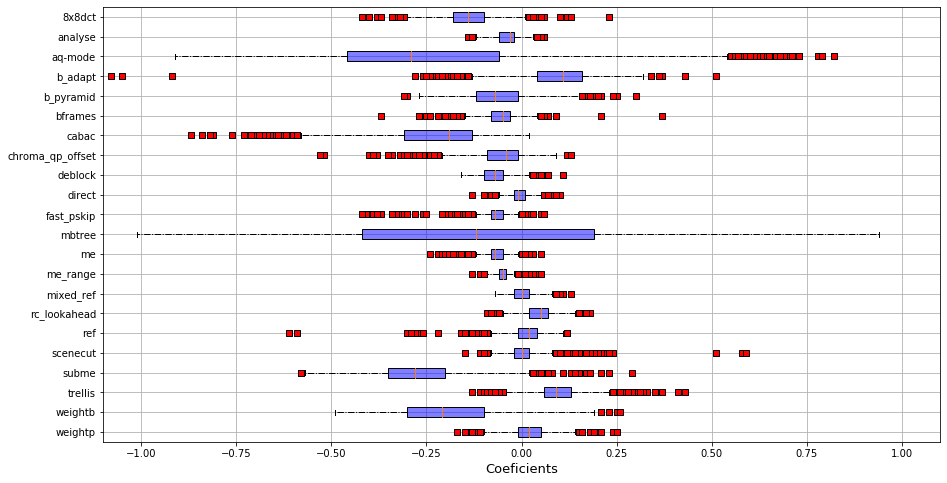

In [27]:
boxplot_imp(res_coef, 
            criteria ='name', 
            name ="../../results/boxplot_features_imp_linear_"+predDimension+".png", 
            xlim = (-1.1,1.1), 
            xname = 'Coeficients')

## RQ1.3 - Ranking and accuracy comparison

### A- Accuracy

def compute_accuracies(listVid, id_short=None):
    
    if not id_short:
        id_short = np.arange(0,len(listVid),1)
        
    listAccuracies = []

    for id_video in range(len(listVid)):

        acc_vid = []
        df = listVid[id_video][to_keep].replace(to_replace ="None",value='0')
        
        df['deblock'] =[int(val[0]) for val in df['deblock']]
        
        for col in df.columns:
            if col not in categorial:
                arr_col = np.array(df[col],int)
                arr_col = (arr_col-np.mean(arr_col))/(np.std(arr_col)+1e-5)
                df[col] = arr_col
            else:
                df[col] = [np.where(k==df[col].unique())[0][0] for k in df[col]]
                arr_col = np.array(df[col],int)
                arr_col = (arr_col-np.mean(arr_col))/(np.std(arr_col)+1e-5)
                df[col] = arr_col
        
        X = df.drop([predDimension], axis=1)
        y = df[predDimension]
        
        for i in range(5):
            
            clf = RandomForestRegressor(n_estimators=200)
            
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

            clf.fit(X_train, y_train)

            y_pred = clf.predict(X_test)
            
            acc_vid.append(np.mean(np.abs((y_test - y_pred) / (y_test + 1e-5)))*100)

        listAccuracies.append(np.mean(acc_vid))

    res = pd.DataFrame({ 'inputs' : v_names, 
                         'accuracy' : listAccuracies})

    return res

res = compute_accuracies(listVideo)
res.to_csv("../../results/shortlist_accuracies"+predDimension+".csv")

pd.Series(res['accuracy']).describe()

df = listVideo[1][to_keep].replace(to_replace ="None",value='0')

df['deblock'] =[int(val[0]) for val in df['deblock']]

for col in df.columns:
    if col not in categorial:
        arr_col = np.array(df[col],int)
        arr_col = (arr_col-np.mean(arr_col))/(np.std(arr_col)+1e-5)
        df[col] = arr_col
    else:
        df[col] = [np.where(k==df[col].unique())[0][0] for k in df[col]]
        arr_col = np.array(df[col],int)
        arr_col = (arr_col-np.mean(arr_col))/(np.std(arr_col)+1e-5)
        df[col] = arr_col

clf = RandomForestRegressor(n_estimators=200)
X = df.drop([predDimension], axis=1)
y = df[predDimension]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

np.mean(np.abs((y_test - y_pred) / y_test)) * 100

### B - Ranking

to_keep = [k for k in listFeatures]
to_keep.append(predDimension)
to_keep.append("ranking")

def compute_ranking(listVid, id_short=None):
    
    if not id_short:
        id_short = np.arange(0,len(listVid),1)
    
    listAccuracies = []

    for id_video in range(len(listVid)):
        
        df = listVid[id_video][to_keep].replace(to_replace ="None",value='0')
        
        df['deblock'] = [int(val[0]) for val in df['deblock']]
        
        for col in df.columns:
            if col not in categorial:
                arr_col = np.array(df[col],int)
                arr_col = (arr_col-np.mean(arr_col))/(np.std(arr_col)+1e-5)
                df[col] = arr_col
            else:
                df[col] = [np.where(k==df[col].unique())[0][0] for k in df[col]]
                arr_col = np.array(df[col],int)
                arr_col = (arr_col-np.mean(arr_col))/(np.std(arr_col)+1e-5)
                df[col] = arr_col
        
        X = df.drop([predDimension, "ranking"], axis=1)
        y = df["ranking"]
            
        clf = RandomForestRegressor(n_estimators=200)

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

        clf.fit(X_train, y_train)

        y_pred = clf.predict(X_test)

        listAccuracies.append(np.mean(np.abs(y_test - y_pred)))

    res = pd.DataFrame({ 'inputs' : v_names, 
                         'MRD' : listAccuracies})

    return res

ranks_prediction = compute_ranking(listVideo)

np.max(ranks_prediction["MRD"])

listVideo[0]

In [28]:
sizes = listVideo[0][predDimension]
ind = sorted(range(len(sizes)), key=lambda k: sizes[k])
df = pd.DataFrame({"index" : range(201), "video0" : ind}).set_index("index")

for i in np.arange(1,len(listVideo),1):
    sizes = listVideo[i][predDimension]
    ind = sorted(range(len(sizes)), key=lambda k: sizes[k])
    df["video"+str(i)] = ind

df.head()

,video0,video1,video2,video3,video4,video5,video6,video7,video8,video9,...,video1387,video1388,video1389,video1390,video1391,video1392,video1393,video1394,video1395,video1396
index,,,,,,,,,,,,,,,,,,,,,
0,166,91,104,171,169,89,26,161,171,104,...,104,169,104,164,170,169,104,170,175,169
1,164,104,105,130,168,170,27,160,32,171,...,32,166,46,175,171,168,171,171,193,168
2,169,100,100,131,170,169,28,163,161,60,...,171,170,190,193,169,165,60,169,164,123
3,165,102,102,132,165,168,21,171,160,32,...,36,165,176,92,184,123,32,60,39,159
4,168,108,108,32,123,165,20,130,163,130,...,35,168,187,112,179,159,4,177,23,170


Config min std :  200
Config max std :  16
Config med std :  58.678078128140996


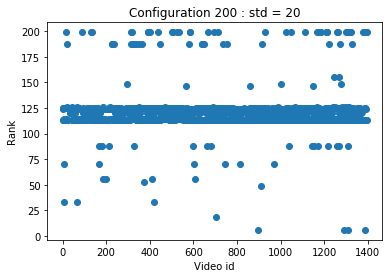

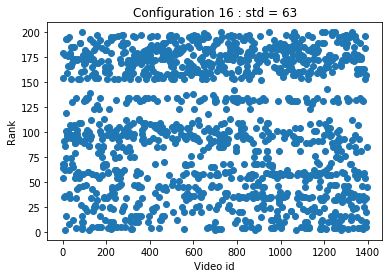

In [29]:
stds = [np.std(df.loc[i,:]) for i in range(len(df.index))]
print("Config min std : ", np.argmin(stds))
print("Config max std : ", np.argmax(stds))

print("Config med std : ", np.median(stds))

plt.scatter(range(len(df.columns)), df.loc[np.argmin(stds), :])
plt.ylabel("Rank")
plt.xlabel("Video id")
plt.title("Configuration "+str(np.argmin(stds))+" : std = "+str(int(np.round(np.min(stds)))))
plt.savefig("../../results/config_min_std_ranking.png")
plt.show()

plt.scatter(range(len(df.columns)), df.loc[np.argmax(stds), :])
plt.ylabel("Rank")
plt.xlabel("Video id")
plt.title("Configuration "+str(np.argmax(stds))+" : std = "+str(int(np.round(np.max(stds)))))
plt.savefig("../../results/config_max_std_ranking.png")
plt.show()

In [30]:
print(np.min(stds))
print(np.max(stds))

19.605143021374648
62.887600399821864


In [31]:
print(np.sum([1  for j in range(len(df.loc[np.argmin(stds),:])) 
              if df.loc[np.argmin(stds),:][j] > 105 and df.loc[np.argmin(stds),:][j] < 130])
      /len(df.loc[np.argmin(stds),:]))

0.9248389405869721


In [32]:
np.where(df.loc[np.argmin(stds),:] == np.min(df.loc[np.argmin(stds),:]))

(array([ 897, 1289, 1311, 1387]),)

In [33]:
np.max(df.loc[np.argmax(stds),:])

200

In [34]:
np.where(df.loc[np.argmax(stds),:] == np.min(df.loc[np.argmax(stds),:]))

(array([  11,  121,  698,  883, 1071, 1279]),)

In [35]:
np.max(df.loc[np.argmax(stds),:])

200

In [36]:
pd.Series(df.loc[np.argmax(stds),:]).describe()

count    1397.000000
mean      107.672155
std        62.910121
min         2.000000
25%        54.000000
50%       103.000000
75%       171.000000
max       200.000000
Name: 16, dtype: float64

# RQ2

## RQ2.1 - Group of performances

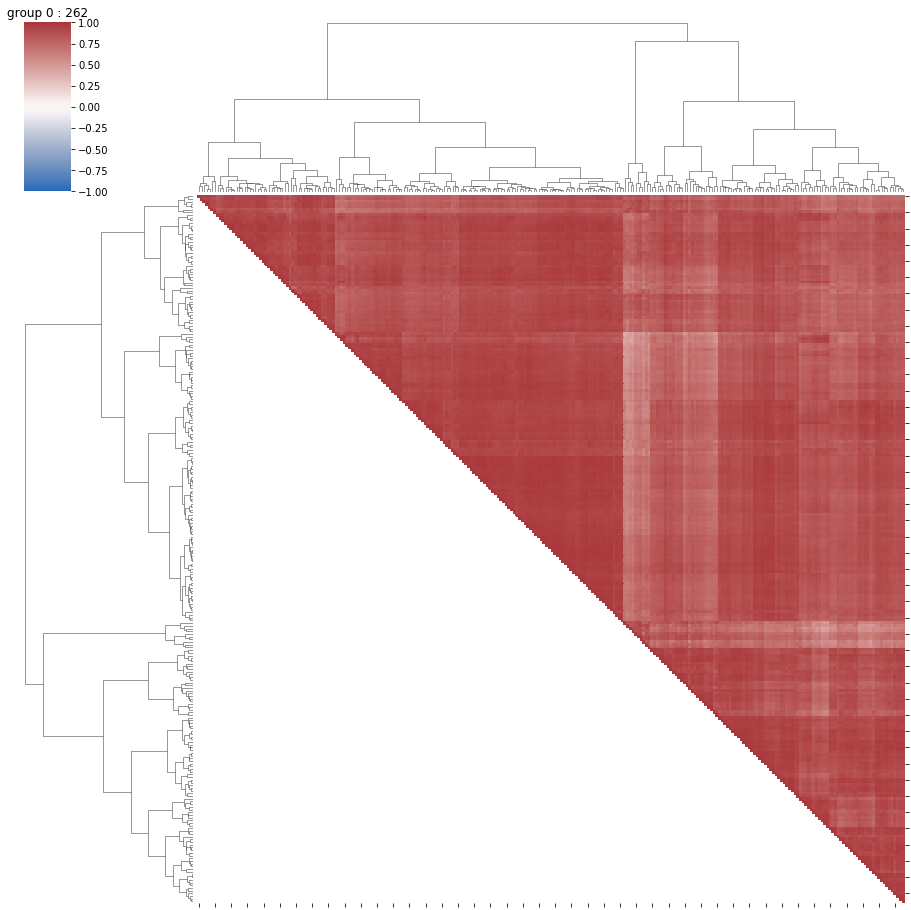

count    34191.000000
mean         0.864382
std          0.084244
min          0.388822
25%          0.821387
50%          0.881748
75%          0.927229
max          0.996812
dtype: float64


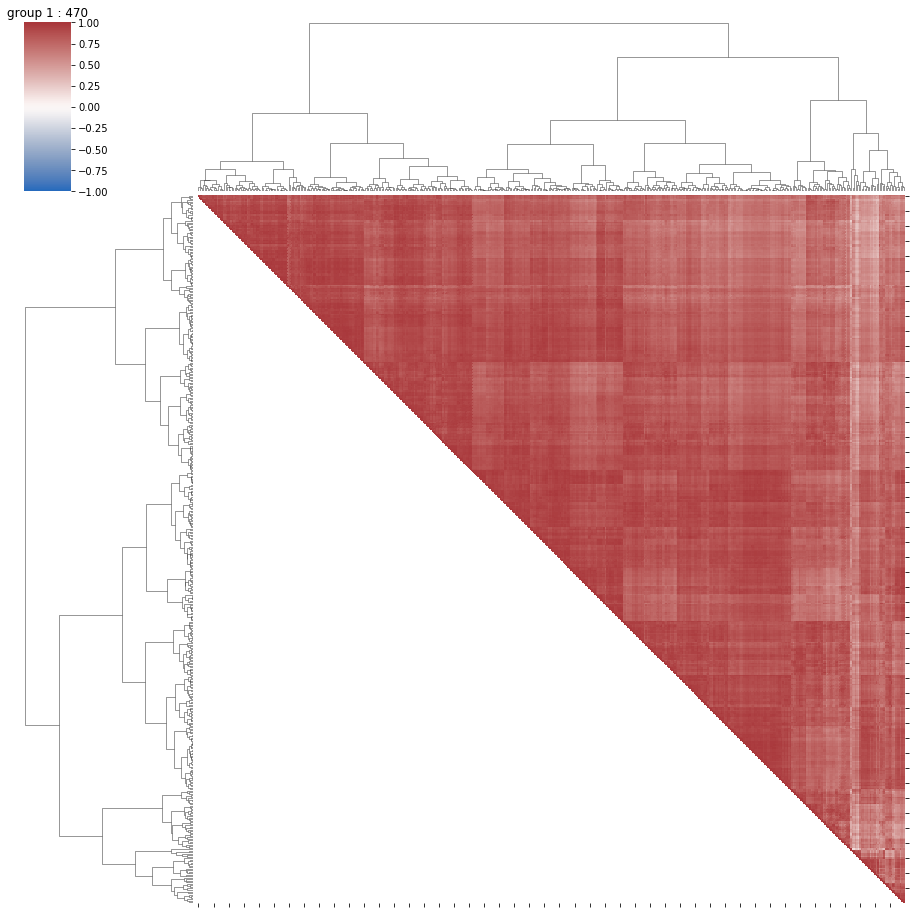

count    110215.000000
mean          0.817088
std           0.105819
min           0.150029
25%           0.758130
50%           0.837072
75%           0.896803
max           0.996081
dtype: float64


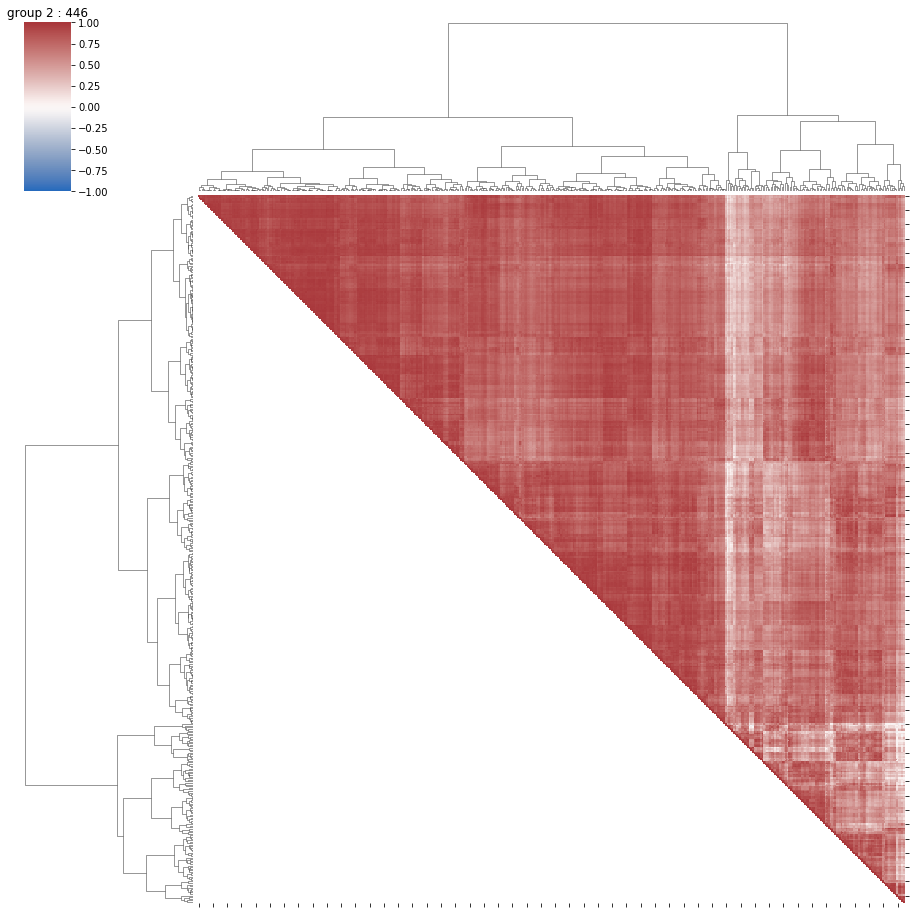

count    99235.000000
mean         0.734612
std          0.167970
min         -0.157552
25%          0.640684
50%          0.772087
75%          0.863354
max          0.994118
dtype: float64


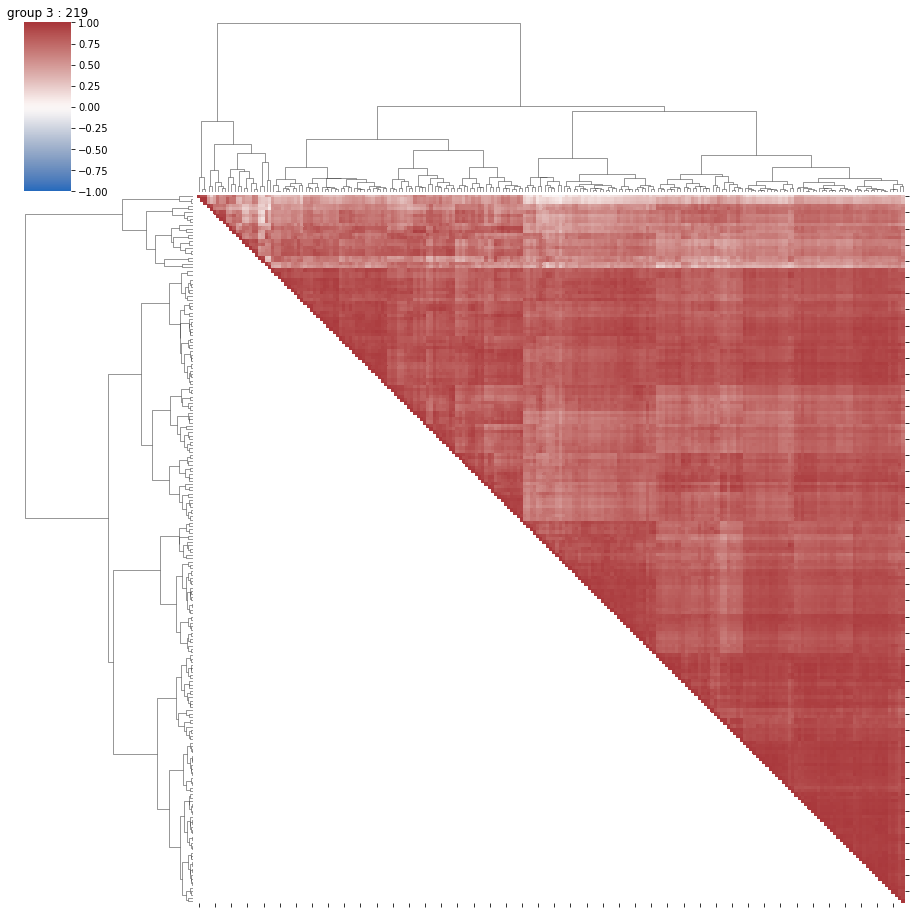

count    23871.000000
mean         0.791402
std          0.138792
min         -0.069959
25%          0.727151
50%          0.823678
75%          0.890600
max          0.997228
dtype: float64


In [37]:
def plot_corr_matrix(corr, method = 'ward', title=''):

    df = pd.DataFrame(corr)
    
    links = linkage(df, method=method,)
    order = leaves_list(links)
    
    mask = np.zeros_like(corr, dtype=np.bool)
    
    for i in range(len(corr)):
        for j in range(len(corr)):
            if i>j:
                mask[order[i]][order[j]] = True
    
    g = sns.clustermap(df, cmap="vlag", mask=mask, method=method,
                   linewidths=0, figsize=(13, 13), vmin=-1)
    g.ax_heatmap.set_yticklabels([])
    g.ax_heatmap.set_xticklabels([])
    plt.title(title)
    plt.show()
    
    corrDescription = [corr[i][j] for i in range(len(corr)) for j in range(len(corr)) if i >j]
    return pd.Series(corrDescription).describe()

def plot_group(group_index):
    ind = np.array([k for k in range(len(corrSpearman)) if groups[k] == group_index], dtype=int)
    group = np.copy([[corrSpearman[k][j] for j in ind] for k in ind])
    print(plot_corr_matrix(group,title="group "+str(group_index)+" : "+str(len(group))))

for i in range(4):
    plot_group(i)

## Summary per group

In [1131]:
meta = pd.read_csv("../../data/ugc_meta/all_features.csv").set_index('FILENAME')
meta['category']=[str(meta.index[i]).split('_')[0] for i in range(meta.shape[0])]
del meta['NOISE_DMOS']
meta = meta.fillna(0)
cat_tab = pd.Series(meta['category'].values).unique()
meta['video_category'] = [np.where(cat_tab==meta['category'][i])[0][0] for i in range(len(meta['category']))]
del meta['category']
for col in meta.columns:#[:len(meta.columns)-1]:
    inter = np.array(meta[col],float)
    meta[col] = (inter-np.mean(inter))/np.std(inter)
perf = pd.DataFrame({'FILENAME': np.array([v_names[k][:-4] for k in range(len(v_names))]),
              'perf_group' : np.array([k for k in groups])}).set_index('FILENAME')
meta_perf = perf.join(meta)
meta_perf

,perf_group,SLEEQ_DMOS,BANDING_DMOS,WIDTH,HEIGHT,SPATIAL_COMPLEXITY,TEMPORAL_COMPLEXITY,CHUNK_COMPLEXITY_VARIATION,COLOR_COMPLEXITY,video_category
FILENAME,,,,,,,,,,
Animation_1080P-01b3,0,-0.678859,4.653015,0.383054,0.332504,-1.475487,-1.547345,-0.892454,-1.210798,-1.618194
Animation_1080P-05f8,1,0.844509,0.741729,0.383054,0.332504,-0.147257,0.444086,2.545710,2.207516,-1.618194
Animation_1080P-0c4f,2,-0.655778,-0.377464,0.383054,0.332504,0.422320,-0.963192,1.054868,-1.232460,-1.618194
Animation_1080P-0cdf,1,-0.294170,-0.059377,0.383054,0.332504,-0.028644,0.430810,-0.103261,-0.448284,-1.618194
Animation_1080P-18f5,1,-0.478821,-0.377464,0.383054,0.332504,1.289017,-0.958767,-0.051295,0.192920,-1.618194
...,...,...,...,...,...,...,...,...,...,...
Vlog_720P-561e,2,-0.678859,-0.377464,-0.239786,-0.333314,0.978979,-1.414583,-0.652893,0.457201,1.494379
Vlog_720P-5d08,1,-0.678859,-0.377464,-0.773092,-0.333314,3.257287,-0.303807,-0.437698,-0.158009,1.494379
Vlog_720P-60f8,1,0.444433,0.623920,-0.239786,-0.333314,0.234418,-0.042708,-0.364385,-0.149344,1.494379


In [39]:
meta_perf['str_video_cat'] = [str(meta_perf.index[i]).split('_')[0] for i in range(meta_perf.shape[0])]
total_cat = meta_perf.groupby('str_video_cat').count()['perf_group']
group_perf = np.array([gr for gr in groups])
group_perf

array([0, 1, 2, ..., 1, 3, 2])

In [40]:
listFeatures = ["cabac", "ref", "deblock", "analyse", "me", "subme", "mixed_ref", "me_range", "trellis", "8x8dct", "fast_pskip", "chroma_qp_offset", "bframes", "b_pyramid", "b_adapt", "direct", "weightb", "open_gop", "weightp", "scenecut", "rc_lookahead", "mbtree", "qpmax", "aq-mode"]

to_keep = [k for k in listFeatures]
to_keep.append(predDimension)

categorial = ['analyse', 'me', 'direct']

def summary_group(id_group):
            
    id_list = [i for i in range(len(listVideo)) if group_perf[i]==id_group]
    v_names_group = [v_names[i][:-4] for i in range(len(v_names)) if i in id_list]
    listVideoGroup = [listVideo[i] for i in range(len(listVideo)) if i in id_list]
    
    print('Group '+str(id_group)+' : '+str(len(listVideoGroup))+' videos!')
    
    print('\n')
    
    video_size = [input_sizes.loc[index_vid]['size'] for index_vid in v_names_group]
    
    print("input avg size :", np.mean(video_size))
    print("input std size :", np.std(video_size))
    
    print('\n')

    # features importances
    res_imp = compute_Importances(listVideoGroup)
    
    print('\n')
    
    print('Imp mbtree:', np.mean(res_imp['mbtree']))
    print('Imp std mbtree:', np.std(res_imp['mbtree']))
    
    print('Imp aq-mode:', np.mean(res_imp['aq-mode']))
    print('Imp std aq-mode:', np.std(res_imp['aq-mode']))
    
    print('Imp subme:', np.mean(res_imp['subme']))
    print('Imp std subme:', np.std(res_imp['subme']))
    
    boxplot_imp(res_imp, criteria = 'name', xlim= (0, 1),
               name ="../../results/boxplot_imp_group"+str(id_group)+".png")

    # features effects
    res_poly = compute_poly(listVideoGroup)
    
    print('\n')
        
    print('Coef mbtree:', np.mean(res_poly['mbtree']))
    print('Coef mbtree std :', np.std(res_poly['mbtree']))
    print('Coef aq-mode:', np.mean(res_poly['aq-mode']))
    print('Coef aq_mode std :', np.std(res_poly['aq-mode']))
    print('Coef subme:', np.mean(res_poly['subme']))
    print('Coef subme std:', np.std(res_poly['subme']))
    
    boxplot_imp(res_poly, criteria = 'name', xlim = (-1, 1),
               name ="../../results/boxplot_effect_group"+str(id_group)+".png", xname = 'Coefficients')

    print('\n')

    interest_var = ['cpu', 'etime', 'fps', 'kbs', 'size']

    for iv in interest_var:
        pred = [np.mean(lv[iv]) for lv in listVideoGroup]
        print('Mean '+iv+' in the group: '+str(np.round(np.mean(pred),1)))
        print('Std dev : '+iv+' in the group: '+str(np.round(np.std(pred),1)))

    print('\n')

    # percentage of the videos present in the group par category

    meta_perf_group = meta_perf.query('perf_group=='+str(id_group))
    meta_perf_group['str_video_cat'] = [str(meta_perf_group.index[i]).split('_')[0] for i in range(meta_perf_group.shape[0])]
    val_group = meta_perf_group.groupby('str_video_cat').count()['perf_group']
    df_res_cat_group = pd.DataFrame({'val': val_group, 'total': total_cat})
    print(df_res_cat_group['val']/df_res_cat_group['total'])

    print('\n')

    # Mean of the videos of the group per properties

    for col in meta_perf_group.columns:
        if col not in ['str_video_cat', 'video_category']:
            print('Mean '+col+' : '+str(meta_perf_group[col].mean()))
            print('std '+col+' : '+str(meta_perf_group[col].std()))

    print('\n')

    corrGroup = np.array([corrSpearman[i][j] for i in range(len(corrSpearman)) if i in id_list 
                 for j in range(len(corrSpearman)) if j in id_list],float)

    print("Correlations intra-group: \n" + str(pd.Series(corrGroup).describe())+'\n')

Group 0 : 262 videos!


input avg size : 2141132249.8625953
input std size : 4106673691.0127487




Imp mbtree: 0.3693511450381679
Imp std mbtree: 0.21900180987310702
Imp aq-mode: 0.04404580152671756
Imp std aq-mode: 0.06938969087645566
Imp subme: 0.3406870229007633
Imp std subme: 0.23753727177108408


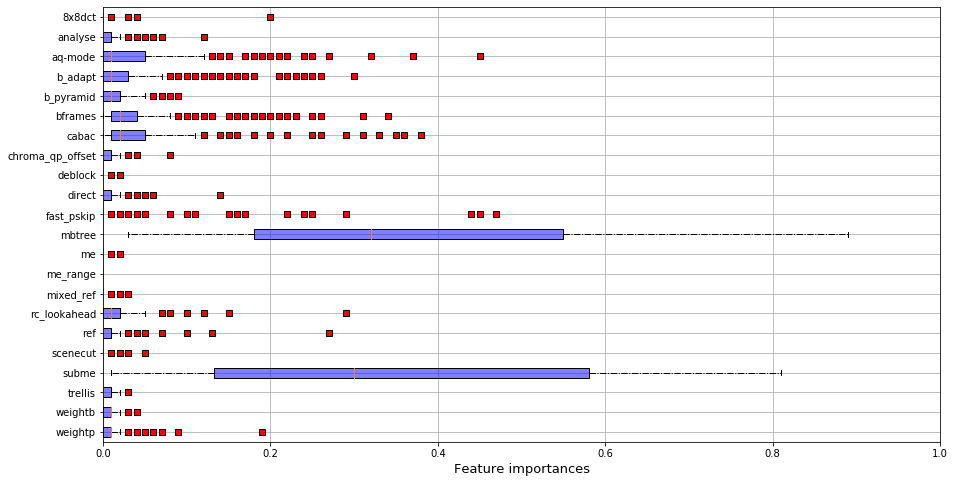



Coef mbtree: -0.4388167938931298
Coef mbtree std : 0.13879708411079755
Coef aq-mode: -0.13419847328244275
Coef aq_mode std : 0.13958747400262136
Coef subme: -0.22740458015267176
Coef subme std: 0.10141056892884777


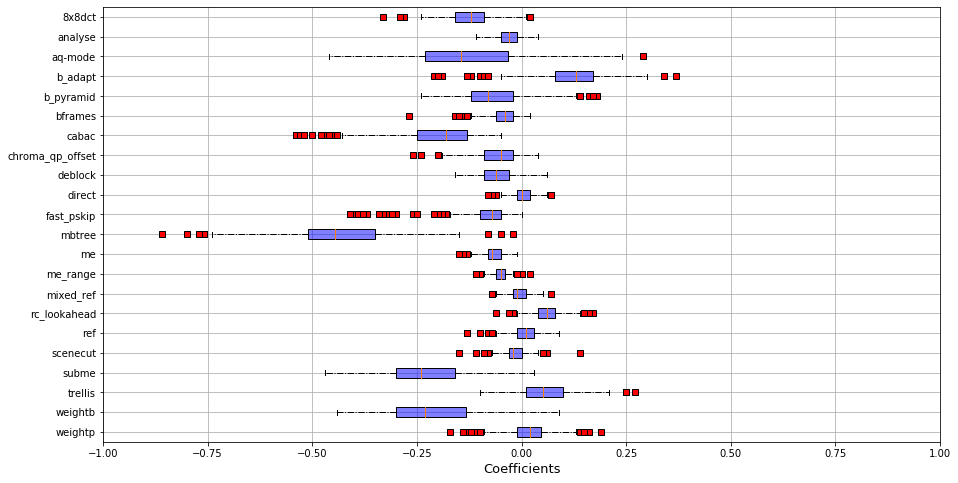



Mean cpu in the group: 795.9
Std dev : cpu in the group: 335.4
Mean etime in the group: 8.5
Std dev : etime in the group: 17.2
Mean fps in the group: 560.9
Std dev : fps in the group: 444.3
Mean kbs in the group: 4570.8
Std dev : kbs in the group: 8610.9
Mean size in the group: 11285335.8
Std dev : size in the group: 21465060.3


str_video_cat
Animation         0.298851
CoverSong         0.240964
Gaming            0.132867
HDR               0.211538
HowTo             0.333333
Lecture           0.355769
LiveMusic         0.148649
LyricVideo        0.300000
MusicVideo        0.166667
NewsClip          0.114583
Sports            0.090323
TelevisionClip    0.327273
VR                0.134831
VerticalVideo     0.144737
Vlog              0.075949
dtype: float64


Mean perf_group : 0.0
std perf_group : 0.0
Mean SLEEQ_DMOS : 0.010585855723199852
std SLEEQ_DMOS : 1.1992390715184256
Mean BANDING_DMOS : 0.2759311078452877
std BANDING_DMOS : 1.481394223882173
Mean WIDTH : -0.0828277760388681
std

/home/llesoil/anaconda3/envs/x264/lib/python3.7/site-packages/ipykernel_launcher.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Correlations intra-group: 
count    68644.000000
mean         0.864899
std          0.084497
min          0.388822
25%          0.821671
50%          0.882167
75%          0.927773
max          1.000000
dtype: float64



In [41]:
summary_group(0)

Group 1 : 470 videos!


input avg size : 1637205973.9170213
input std size : 2438557837.558484




Imp mbtree: 0.08995744680851064
Imp std mbtree: 0.09468873024829515
Imp aq-mode: 0.2752340425531915
Imp std aq-mode: 0.19419623906408817
Imp subme: 0.48614893617021276
Imp std subme: 0.24510236495672355


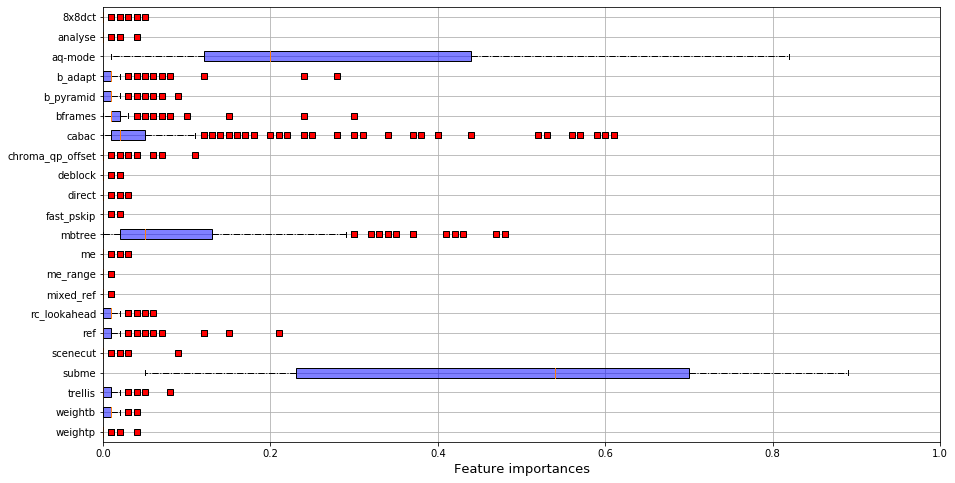



Coef mbtree: 0.3331063829787234
Coef mbtree std : 0.19396788877067048
Coef aq-mode: -0.5040851063829788
Coef aq_mode std : 0.13980804922909124
Coef subme: -0.3180851063829787
Coef subme std: 0.09194212559556819


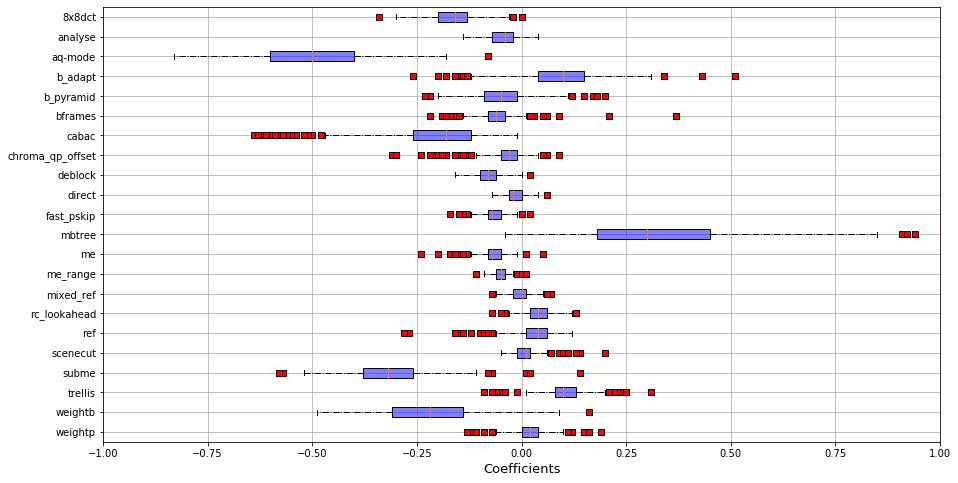



Mean cpu in the group: 1074.5
Std dev : cpu in the group: 398.9
Mean etime in the group: 8.9
Std dev : etime in the group: 10.7
Mean fps in the group: 389.4
Std dev : fps in the group: 302.9
Mean kbs in the group: 15015.6
Std dev : kbs in the group: 19927.0
Mean size in the group: 37383809.7
Std dev : size in the group: 49629655.1


str_video_cat
Animation         0.252874
CoverSong         0.277108
Gaming            0.363636
HDR               0.057692
HowTo             0.252874
Lecture           0.086538
LiveMusic         0.324324
LyricVideo        0.216667
MusicVideo        0.282051
NewsClip          0.489583
Sports            0.567742
TelevisionClip    0.254545
VR                0.426966
VerticalVideo     0.289474
Vlog              0.449367
dtype: float64


Mean perf_group : 1.0
std perf_group : 0.0
Mean SLEEQ_DMOS : -0.029323948203180957
std SLEEQ_DMOS : 0.9164326353194944
Mean BANDING_DMOS : -0.1830523651266118
std BANDING_DMOS : 0.5248708286866567
Mean WIDTH : -0.06749438276653

/home/llesoil/anaconda3/envs/x264/lib/python3.7/site-packages/ipykernel_launcher.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Correlations intra-group: 
count    220900.000000
mean          0.817477
std           0.106042
min           0.150029
25%           0.758339
50%           0.837350
75%           0.897184
max           1.000000
dtype: float64



In [42]:
summary_group(1)

Group 2 : 446 videos!


input avg size : 1912740394.618834
input std size : 4485849929.210282




Imp mbtree: 0.05800448430493275
Imp std mbtree: 0.07069044485178973
Imp aq-mode: 0.14650224215246638
Imp std aq-mode: 0.18061270593881887
Imp subme: 0.5131838565022422
Imp std subme: 0.24255034576899911


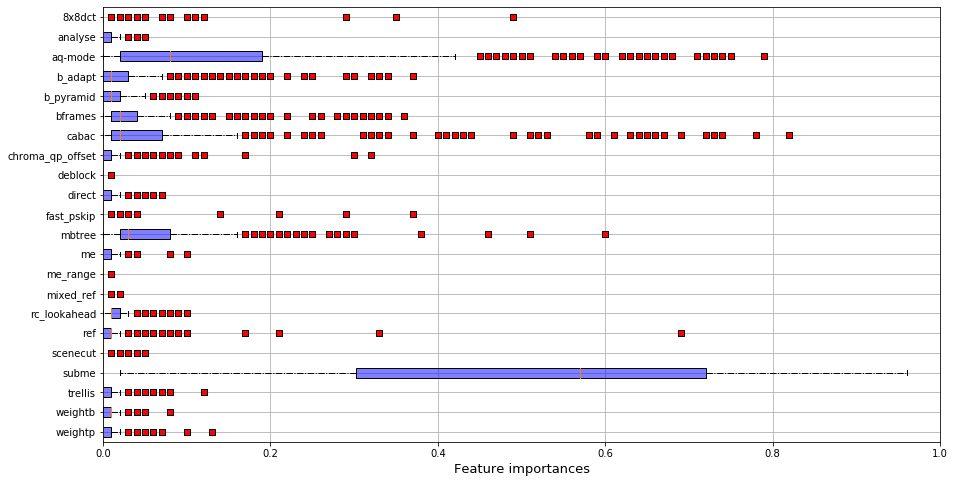



Coef mbtree: -0.12002242152466368
Coef mbtree std : 0.148267270001769
Coef aq-mode: -0.27849775784753367
Coef aq_mode std : 0.18165712971210848
Coef subme: -0.2888565022421524
Coef subme std: 0.10825684472962907


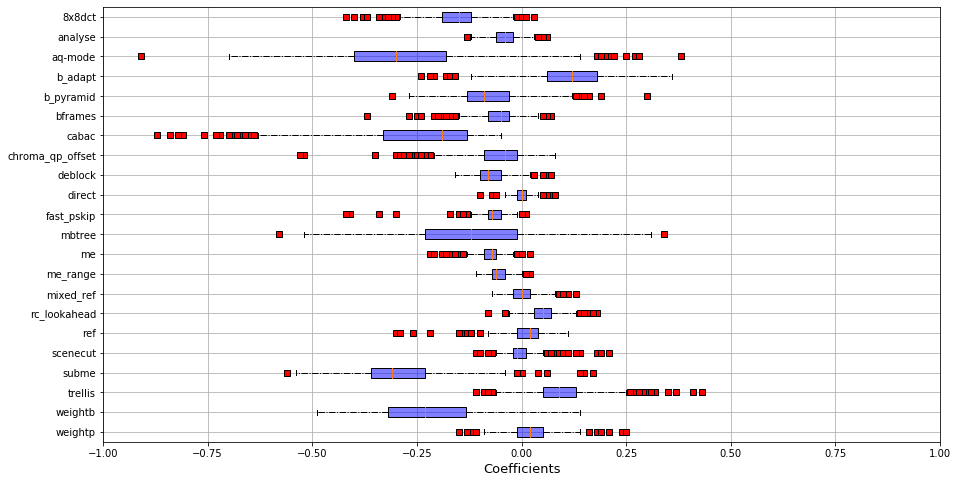



Mean cpu in the group: 916.9
Std dev : cpu in the group: 357.9
Mean etime in the group: 8.8
Std dev : etime in the group: 19.3
Mean fps in the group: 475.7
Std dev : fps in the group: 358.2
Mean kbs in the group: 7472.1
Std dev : kbs in the group: 11682.3
Mean size in the group: 18442636.1
Std dev : size in the group: 28996660.7


str_video_cat
Animation         0.321839
CoverSong         0.265060
Gaming            0.363636
HDR               0.211538
HowTo             0.310345
Lecture           0.317308
LiveMusic         0.391892
LyricVideo        0.300000
MusicVideo        0.397436
NewsClip          0.333333
Sports            0.277419
TelevisionClip    0.345455
VR                0.348315
VerticalVideo     0.368421
Vlog              0.265823
dtype: float64


Mean perf_group : 2.0
std perf_group : 0.0
Mean SLEEQ_DMOS : 0.02205119993363216
std SLEEQ_DMOS : 1.007966622413751
Mean BANDING_DMOS : -0.05208667635743455
std BANDING_DMOS : 0.8682899951397716
Mean WIDTH : -0.1364359113106732
s

/home/llesoil/anaconda3/envs/x264/lib/python3.7/site-packages/ipykernel_launcher.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Correlations intra-group: 
count    198916.000000
mean          0.735207
std           0.168250
min          -0.157552
25%           0.641021
50%           0.772543
75%           0.863975
max           1.000000
dtype: float64



In [43]:
summary_group(2)

Group 3 : 219 videos!


input avg size : 4415585852.876713
input std size : 7212521059.6005535




Imp mbtree: 0.4737442922374429
Imp std mbtree: 0.19527675806175948
Imp aq-mode: 0.134337899543379
Imp std aq-mode: 0.12749749743150193
Imp subme: 0.14429223744292238
Imp std subme: 0.1428695687822811


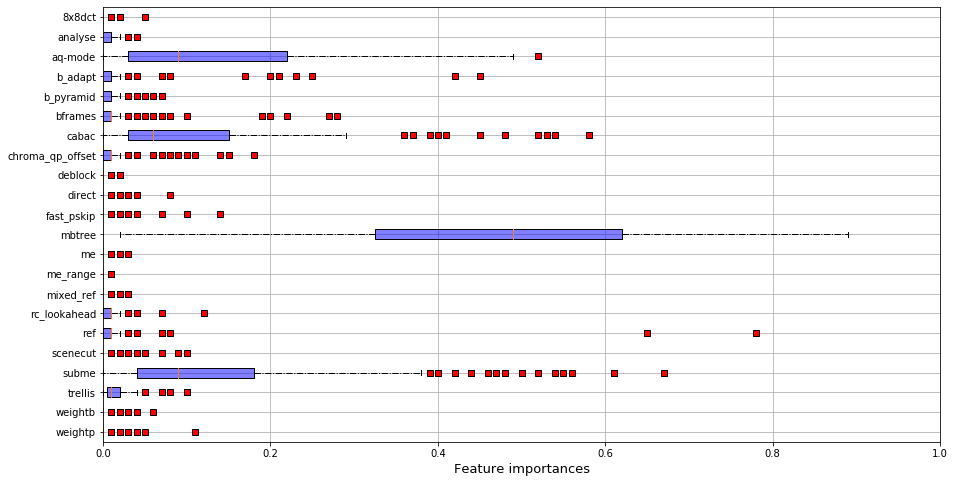



Coef mbtree: -0.6810502283105022
Coef mbtree std : 0.1800641494960555
Coef aq-mode: 0.35538812785388135
Coef aq_mode std : 0.20981446477958007
Coef subme: -0.16118721461187216
Coef subme std: 0.1238590177374664


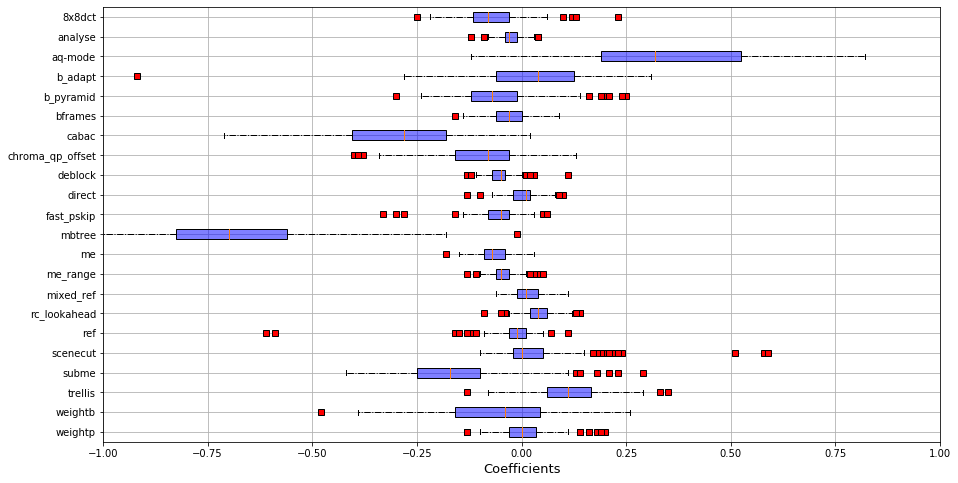



Mean cpu in the group: 1029.7
Std dev : cpu in the group: 377.2
Mean etime in the group: 19.1
Std dev : etime in the group: 30.4
Mean fps in the group: 244.2
Std dev : fps in the group: 256.7
Mean kbs in the group: 9223.9
Std dev : kbs in the group: 11328.4
Mean size in the group: 22805170.5
Std dev : size in the group: 28350618.9


str_video_cat
Animation         0.126437
CoverSong         0.216867
Gaming            0.139860
HDR               0.519231
HowTo             0.103448
Lecture           0.240385
LiveMusic         0.135135
LyricVideo        0.183333
MusicVideo        0.153846
NewsClip          0.062500
Sports            0.064516
TelevisionClip    0.072727
VR                0.089888
VerticalVideo     0.197368
Vlog              0.208861
dtype: float64


Mean perf_group : 3.0
std perf_group : 0.0
Mean SLEEQ_DMOS : 0.005360393998249836
std SLEEQ_DMOS : 0.8958933053763064
Mean BANDING_DMOS : 0.1688188082623658
std BANDING_DMOS : 1.20468743040557
Mean WIDTH : 0.521797505328845
std

/home/llesoil/anaconda3/envs/x264/lib/python3.7/site-packages/ipykernel_launcher.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Correlations intra-group: 
count    47961.000000
mean         0.792355
std          0.139186
min         -0.069959
25%          0.727816
50%          0.824228
75%          0.891512
max          1.000000
dtype: float64



In [44]:
summary_group(3)

### Inter-group correlogram

In [45]:
group_perf =groups
id_list_0 = [i for i in range(len(listVideo)) if group_perf[i]==1]
id_list_1 = [i for i in range(len(listVideo)) if group_perf[i]==3]
id_list_2 = [i for i in range(len(listVideo)) if group_perf[i]==0]
id_list_3 = [i for i in range(len(listVideo)) if group_perf[i]==2]

res = np.zeros(16).reshape(4,4)
stds = np.zeros(16).reshape(4,4)
res_med = np.zeros(16).reshape(4,4)

tab = []
for id0 in id_list_0:
    for id1 in id_list_1:
        tab.append(corrSpearman[id0][id1])
res[0][1] = np.mean(tab)
stds[0][1] = np.std(tab)
res_med[0][1] = np.median(tab)

tab = []
for id0 in id_list_0:
    for id2 in id_list_2:
        tab.append(corrSpearman[id0][id2])
res[0][2] = np.mean(tab)
stds[0][2] = np.std(tab)
res_med[0][2] = np.median(tab)

tab = []
for id0 in id_list_0:
    for id3 in id_list_3:
        tab.append(corrSpearman[id0][id3])
res[0][3] = np.mean(tab)
stds[0][3] = np.std(tab)
res_med[0][3] = np.median(tab)

tab = []
for id1 in id_list_1:
    for id2 in id_list_2:
        tab.append(corrSpearman[id1][id2])
res[1][2] = np.mean(tab)
stds[1][2] = np.std(tab)
res_med[1][2] = np.median(tab)

tab = []
for id1 in id_list_1:
    for id3 in id_list_3:
        tab.append(corrSpearman[id1][id3])
res[1][3] = np.mean(tab)
stds[1][3] = np.std(tab)
res_med[1][3] = np.median(tab)

tab = []
for id2 in id_list_2:
    for id3 in id_list_3:
        tab.append(corrSpearman[id2][id3])
res[2][3] = np.mean(tab)
stds[2][3] = np.std(tab)
res_med[2][3] = np.median(tab)


res[0][0] = np.mean([[corrSpearman[id1][id2] for id1 in id_list_0] for id2 in id_list_0])
res[1][1] = np.mean([[corrSpearman[id1][id2] for id1 in id_list_1] for id2 in id_list_1])
res[2][2] = np.mean([[corrSpearman[id1][id2] for id1 in id_list_2] for id2 in id_list_2])
res[3][3] = np.mean([[corrSpearman[id1][id2] for id1 in id_list_3] for id2 in id_list_3])

print("AVG")
print(res)
print("STD")
print(stds)
print('MEDIAN')
print(res_med)

AVG
[[0.81747714 0.04144966 0.36253517 0.59097558]
 [0.         0.79235455 0.68081324 0.46116805]
 [0.         0.         0.8648994  0.72056058]
 [0.         0.         0.         0.73520697]]
STD
[[0.         0.21617253 0.18632293 0.17803149]
 [0.         0.         0.1739558  0.20649183]
 [0.         0.         0.         0.15524317]
 [0.         0.         0.         0.        ]]
MEDIAN
[[0.         0.04818101 0.36961349 0.60762731]
 [0.         0.         0.71799915 0.48859154]
 [0.         0.         0.         0.74609453]
 [0.         0.         0.         0.        ]]


In [46]:
tab = [v_names[i].split("_")[1].split("-")[0] for i in id_list_1]
resolutions = ['360P','480P','720P','1080P', '2160P']
for r in resolutions:
    print(r, " : ", tab.count(r))
(89+52)/len(tab)

360P  :  14
480P  :  24
720P  :  40
1080P  :  89
2160P  :  52


0.6438356164383562

In [47]:
tab = [v_names[i].split("_")[1].split("-")[0] for i in id_list_3]
resolutions = ['360P','480P','720P','1080P', '2160P']
for r in resolutions:
    print(r, " : ", tab.count(r))
(88+108+96)/len(tab)

360P  :  88
480P  :  108
720P  :  96
1080P  :  114
2160P  :  40


0.6547085201793722

In [48]:
tab = [v_names[i].split("_")[1].split("-")[0] for i in id_list_2]
resolutions = ['360P','480P','720P','1080P', '2160P']
for r in resolutions:
    print(r, " : ", tab.count(r))

360P  :  59
480P  :  59
720P  :  56
1080P  :  56
2160P  :  32


In [49]:
tab = [v_names[i].split("_")[1].split("-")[0] for i in id_list_0]
resolutions = ['360P','480P','720P','1080P', '2160P']
for r in resolutions:
    print(r, " : ", tab.count(r))

360P  :  75
480P  :  104
720P  :  110
1080P  :  136
2160P  :  45


## RQ2.2 - Group classification

In [563]:
if 'str_video_cat' in meta_perf.columns:
    del meta_perf['str_video_cat']

accuracy = []

nbLaunches =10
for i in range(nbLaunches):
    X = np.array(meta_perf[[k for k in meta_perf.columns if k !='perf_group']], float)
    y = np.array(meta_perf['perf_group'], float)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

    rf = RandomForestClassifier()
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)


    conf = pd.crosstab(y_pred, y_test)#, colnames=[1,2,3], rownames=[1,2,3])
    val = np.sum(np.diag(conf))/len(y_test)
    accuracy.append(val)
    print('Test accuracy : '+ str(val))
    conf.columns = pd.Int64Index([1,2,3,4], dtype='int64', name='Observed')
    conf.index = pd.Int64Index([1,2,3,4], dtype='int64', name='Predicted')
    conf
print(np.mean(accuracy))
conf

Test accuracy : 0.6571428571428571
Test accuracy : 0.6428571428571429
Test accuracy : 0.6642857142857143
Test accuracy : 0.6642857142857143
Test accuracy : 0.6047619047619047
Test accuracy : 0.6452380952380953
Test accuracy : 0.6357142857142857
Test accuracy : 0.6761904761904762
Test accuracy : 0.6071428571428571
Test accuracy : 0.6404761904761904
0.6438095238095236


Observed,1,2,3,4
Predicted,,,,
1,38,1,12,19
2,1,118,33,1
3,25,27,75,14
4,8,0,10,38


In [564]:
meta_perf

,perf_group,SLEEQ_DMOS,BANDING_DMOS,NOISE_DMOS,WIDTH,HEIGHT,SPATIAL_COMPLEXITY,TEMPORAL_COMPLEXITY,CHUNK_COMPLEXITY_VARIATION,COLOR_COMPLEXITY,video_category
FILENAME,,,,,,,,,,,
Animation_1080P-01b3,0,0.000,0.521,0,1920,1080,0.098,0.004,0.017,0.005,0
Animation_1080P-05f8,1,0.198,0.189,0.172,1920,1080,1.229,0.454,15.962,0.794,0
Animation_1080P-0c4f,2,0.003,0.094,0.047,1920,1080,1.714,0.136,9.048,0.000,0
Animation_1080P-0cdf,1,0.050,0.121,0.111,1920,1080,1.330,0.451,3.677,0.181,0
Animation_1080P-18f5,1,0.026,0.094,0,1920,1080,2.452,0.137,3.918,0.329,0
...,...,...,...,...,...,...,...,...,...,...,...
Vlog_720P-561e,2,0.000,0.094,0,1280,720,2.188,0.034,1.128,0.390,14
Vlog_720P-5d08,1,0.000,0.094,0,732,720,4.128,0.285,2.126,0.248,14
Vlog_720P-60f8,1,0.146,0.179,0.108,1280,720,1.554,0.344,2.466,0.250,14


In [52]:
feat_imp = pd.DataFrame({'Random forest importance' : rf.feature_importances_,
              'name' : meta_perf.columns[1:]}).set_index('name')

In [53]:
feat_imp

,Random forest importance
name,
SLEEQ_DMOS,0.074624
BANDING_DMOS,0.051933
WIDTH,0.042325
HEIGHT,0.038531
SPATIAL_COMPLEXITY,0.295304
TEMPORAL_COMPLEXITY,0.177745
CHUNK_COMPLEXITY_VARIATION,0.151788
COLOR_COMPLEXITY,0.104068
video_category,0.063682


In [54]:
meta_perf.groupby(['perf_group']).mean()

,SLEEQ_DMOS,BANDING_DMOS,WIDTH,HEIGHT,SPATIAL_COMPLEXITY,TEMPORAL_COMPLEXITY,CHUNK_COMPLEXITY_VARIATION,COLOR_COMPLEXITY,video_category
perf_group,,,,,,,,,
0,0.010586,0.275931,-0.082828,-0.065547,-0.506937,-0.683479,-0.535766,-0.071691,-0.277446
1,-0.029324,-0.183052,-0.067494,-0.080484,0.796207,0.240037,0.591315,-0.082578,0.213872
2,0.022051,-0.052087,-0.136436,-0.124786,-0.073861,-0.116045,-0.084998,0.072350,-0.007572
3,0.005360,0.168819,0.521798,0.505276,-0.951862,0.538858,-0.454968,0.115648,-0.111652


## SALib

In [55]:
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.test_functions import Ishigami
import numpy as np

In [56]:
problem = {
    'num_vars': 3,
    'names': ['x1', 'x2', 'x3'],
    'bounds': [[-3.14159265359, 3.14159265359],
               [-3.14159265359, 3.14159265359],
               [-3.14159265359, 3.14159265359]]
}

In [57]:
param_values = saltelli.sample(problem, 1000)

In [58]:
Y_test = np.zeros([param_values.shape[0]])

def f(X, a, b):
    return X[0]+a*(np.sin(X[1])**2)+b*(X[0]**3)*np.sin(X[0])

for i, X in enumerate(param_values):
    Y_test[i] = f(X, 7, 0.1)

Y = Ishigami.evaluate(param_values)

In [59]:
Y

array([1.29855261, 3.17651742, 5.76778927, ..., 2.84553672, 6.07488669,
       6.19510567])

In [60]:
Y_test

array([1.0557915 , 3.51387134, 5.52502817, ..., 2.87064947, 6.22021841,
       6.22021841])

In [61]:
Y = Ishigami.evaluate(param_values)

In [62]:
Si = sobol.analyze(problem, Y)

In [63]:
print(Si['S1'])

[ 0.30797549  0.44776661 -0.00425452]


## RQ2.3 - Generate a configuration

### Learning the encoding size

 #### 1. Aggregation

In [599]:
# input properties name
input_prop = ['SLEEQ_DMOS', 'BANDING_DMOS', 'WIDTH', 'HEIGHT', 
              'SPATIAL_COMPLEXITY', 'TEMPORAL_COMPLEXITY', 'CHUNK_COMPLEXITY_VARIATION', 'COLOR_COMPLEXITY']

# list of software features
listFeatures = ["cabac", "ref", "deblock", "analyse", "me", "subme", "mixed_ref", "me_range", 
                "trellis", "8x8dct", "fast_pskip", "chroma_qp_offset", "bframes", "b_pyramid", 
                "b_adapt", "direct", "weightb", "open_gop", "weightp", "scenecut", "rc_lookahead", 
                "mbtree", "qpmax", "aq-mode"]

# we add the dimension to predict, here the encoding size of the output video
to_keep = [k for k in listFeatures]
to_keep.append(predDimension)

# the categorial feature we have to transform
categorial = ['analyse', 'me', 'direct']

# here, 1 config = 1 set of input properties + 1 software configuration options set
configs = []

# we aggregate the different input video csvs
for input_index in range(len(v_names)):
    input_name = v_names[input_index][:-4]
    input_data = listVideo[input_index][to_keep].replace(to_replace ="None",value='0')
    input_data['deblock'] =[int(val[0]) for val in input_data['deblock']]
    for col in input_data.columns:
        if col not in categorial:
            arr_col = np.array(input_data[col],int)
            arr_col = (arr_col-np.mean(arr_col))/(np.std(arr_col)+1e-5)
            input_data[col] = arr_col
        else:
            input_data[col] = [np.where(k==input_data[col].unique())[0][0] for k in input_data[col]]
            arr_col = np.array(input_data[col],int)
            arr_col = (arr_col-np.mean(arr_col))/(np.std(arr_col)+1e-5)
            input_data[col] = arr_col
    for i in range(len(input_data.index)):
        configs.append(tuple(meta_perf.loc[input_name].loc[input_prop])+tuple(input_data.loc[i]))

KeyboardInterrupt: 

In [65]:
df = pd.DataFrame(configs)
df.columns = tuple(input_prop)+tuple(to_keep)
df

,SLEEQ_DMOS,BANDING_DMOS,WIDTH,HEIGHT,SPATIAL_COMPLEXITY,TEMPORAL_COMPLEXITY,CHUNK_COMPLEXITY_VARIATION,COLOR_COMPLEXITY,cabac,ref,...,direct,weightb,open_gop,weightp,scenecut,rc_lookahead,mbtree,qpmax,aq-mode,size
0,-0.678859,4.653015,0.383054,0.332504,-1.475487,-1.547345,-0.892454,-1.210798,-1.463056,-0.773348,...,-1.676144,-2.038047,0.0,-1.652973,-1.737814,-1.112186,-1.168183,0.0,-1.479994,0.311051
1,-0.678859,4.653015,0.383054,0.332504,-1.475487,-1.547345,-0.892454,-1.210798,0.683471,-0.585615,...,-0.333893,0.490641,0.0,-0.339741,-1.737814,1.522974,0.855996,0.0,0.675649,-0.148509
2,-0.678859,4.653015,0.383054,0.332504,-1.475487,-1.547345,-0.892454,-1.210798,0.683471,-0.585615,...,1.008358,0.490641,0.0,-0.339741,-1.737814,-0.672993,0.855996,0.0,-1.479994,-0.350696
3,-0.678859,4.653015,0.383054,0.332504,-1.475487,-1.547345,-0.892454,-1.210798,0.683471,-0.585615,...,-0.333893,0.490641,0.0,-0.339741,-1.737814,-0.672993,0.855996,0.0,-1.479994,-0.340494
4,-0.678859,4.653015,0.383054,0.332504,-1.475487,-1.547345,-0.892454,-1.210798,0.683471,2.042646,...,1.008358,0.490641,0.0,-0.339741,0.575435,0.205394,-1.168183,0.0,0.675649,-0.191397
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280792,0.629083,-0.353902,-0.239786,-0.333314,-0.329287,0.329026,1.646979,0.565512,0.683471,-0.585615,...,1.008358,0.490641,0.0,-0.339741,0.575435,-0.233799,0.855996,0.0,0.675649,-1.007676
280793,0.629083,-0.353902,-0.239786,-0.333314,-0.329287,0.329026,1.646979,0.565512,0.683471,-0.585615,...,1.008358,0.490641,0.0,-0.339741,0.575435,0.205394,0.855996,0.0,0.675649,-0.940605
280794,0.629083,-0.353902,-0.239786,-0.333314,-0.329287,0.329026,1.646979,0.565512,0.683471,-0.022416,...,-0.333893,0.490641,0.0,-0.339741,0.575435,0.205394,0.855996,0.0,0.675649,-0.127288
280795,0.629083,-0.353902,-0.239786,-0.333314,-0.329287,0.329026,1.646979,0.565512,-1.463056,-0.397882,...,1.008358,0.490641,0.0,0.973490,0.575435,0.205394,-1.168183,0.0,0.675649,0.808647


In [66]:
clf = RandomForestRegressor(n_estimators=200)
X = df.drop([predDimension],axis=1)
y = df[predDimension]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
clf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [67]:
y_pred = clf.predict(X_test)

In [68]:
def median_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.median(np.abs((y_true - y_pred) / y_true)) * 100

In [69]:
median_absolute_percentage_error(y_test, y_pred)

8.266327957598046

In [70]:
def mean_absolute_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs(y_true - y_pred))

In [71]:
mean_absolute_error(y_test, y_pred)

0.10720694042224095

In [72]:
s = pd.Series(clf.feature_importances_)
s.index = tuple(input_prop)+tuple(listFeatures)
s

SLEEQ_DMOS                    0.020102
BANDING_DMOS                  0.010855
WIDTH                         0.007782
HEIGHT                        0.006593
SPATIAL_COMPLEXITY            0.101412
TEMPORAL_COMPLEXITY           0.068762
CHUNK_COMPLEXITY_VARIATION    0.032362
COLOR_COMPLEXITY              0.031322
cabac                         0.042978
ref                           0.002725
deblock                       0.000690
analyse                       0.002913
me                            0.002284
subme                         0.499782
mixed_ref                     0.000747
me_range                      0.000444
trellis                       0.006877
8x8dct                        0.000838
fast_pskip                    0.002868
chroma_qp_offset              0.002991
bframes                       0.013128
b_pyramid                     0.008152
b_adapt                       0.008774
direct                        0.002879
weightb                       0.007604
open_gop                 

#### 2.  Video per video

In [73]:
def compute_accuracies(listVid, id_short=None):
    
    if not id_short:
        id_short = np.arange(0,len(listVid),1)
        
    listAccuracies = []

    for id_video in range(len(listVid)):

        acc_vid = []
        df = listVid[id_video][to_keep].replace(to_replace ="None",value='0')
        
        df['deblock'] =[int(val[0]) for val in df['deblock']]
        
        for col in df.columns:
            if col not in categorial:
                arr_col = np.array(df[col],int)
                arr_col = (arr_col-np.mean(arr_col))/(np.std(arr_col)+1e-5)
                df[col] = arr_col
            else:
                df[col] = [np.where(k==df[col].unique())[0][0] for k in df[col]]
                arr_col = np.array(df[col],int)
                arr_col = (arr_col-np.mean(arr_col))/(np.std(arr_col)+1e-5)
                df[col] = arr_col
        
        X = df.drop([predDimension], axis=1)
        y = df[predDimension]
            
        clf = RandomForestRegressor(n_estimators=200)

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

        clf.fit(X_train, y_train)

        y_pred = clf.predict(X_test)
        
        listAccuracies.append(median_absolute_percentage_error(y_test, y_pred))

    return listAccuracies

res = compute_accuracies(listVideo)

In [74]:
np.median(res)

11.354266215409629

#### Tune table

In [75]:
for i in range(len(v_names)):
    #i=0
    v = v_names[1][:-4]
    if v in meta_perf.index:
        meta_data = meta_perf.loc[v]
        vid = listVideo[i]
        sizes = vid[predDimension]
        listVideo[i]["order"] = sorted(range(len(sizes)), key=lambda k: sizes[k])
vid.groupby("cabac").mean()["order"]

cabac
0     95.812500
1    101.956204
Name: order, dtype: float64

In [76]:
list_properties = ['SLEEQ_DMOS', 'BANDING_DMOS', 'WIDTH', 'HEIGHT', 
                   'SPATIAL_COMPLEXITY', 'TEMPORAL_COMPLEXITY', 
                   'CHUNK_COMPLEXITY_VARIATION', 'COLOR_COMPLEXITY']
listFeatures = ["cabac", "ref", "deblock", "analyse", "me", "subme", "mixed_ref", 
                "me_range", "trellis", "8x8dct", "fast_pskip", "chroma_qp_offset", "bframes", 
                "b_pyramid", "b_adapt", "direct", "weightb", "open_gop", "weightp", "scenecut", 
                "rc_lookahead", "mbtree", "qpmax", "aq-mode"]

list_video_train, list_video_test = train_test_split(v_names, test_size=0.3)

vid = listVideo[0]

feature_labels = dict()

for lf in listFeatures:
    feature_labels[lf] = tuple(vid.groupby(lf).mean()["order"].index)

prop = dict()

for index_prop in range(len(list_properties)):
    prop_name = list_properties[index_prop]
    # get all input properties
    var = meta_perf[prop_name]
    # separate videos into 4 classes delimited by perc 25%, 50%, 75%
    prop[prop_name] = [np.percentile(var, 25), np.median(var), np.percentile(var, 75)]

vid_prop = dict()

for i in range(len(v_names)):
    # each input name
    v = v_names[i][:-4]
    # without .csv
    if v in meta_perf.index:
        vid = meta_perf.loc[v]
        prop_indexes = []
        for index_prop in range(len(list_properties)):
            prop_name = list_properties[index_prop]
            ref_quartile_prop = prop[prop_name]
            index_quartile = 0
            break_cond = False
            while index_quartile < 3 and not break_cond:
                if vid[prop_name] > ref_quartile_prop[index_quartile]:
                    index_quartile+=1
                else:
                    break_cond = True
            prop_indexes.append(index_quartile)
        #prop_indexes.append(v.split('_')[0])
        vid_prop[v] = prop_indexes 
#print(vid_prop)

tune_table = dict()

for p in range(len(list_properties)):
    for f in listFeatures:
        for p_index in range(4):
            list_video_pf = [tuple(listVideo[k].groupby(f).mean()["order"])
                           for k in range(len(v_names)) if v_names[k][:-4] in meta_perf.index 
                             and v_names[k] in list_video_train
                           and vid_prop[v_names[k][:-4]][p] == p_index]
            tune_table_element = []
            for j in range(len(list_video_pf[0])):
                tune_table_element.append(np.mean([k[j] for k in list_video_pf]))
            tune_table[(f, list_properties[p], p_index)] = tune_table_element
tune_table

{('cabac', 'SLEEQ_DMOS', 0): [98.44045064377683, 100.72854860436703],
 ('cabac', 'SLEEQ_DMOS', 1): [98.98197115384616, 100.47557551937113],
 ('cabac', 'SLEEQ_DMOS', 2): [99.35553385416667, 100.30106447688564],
 ('cabac', 'SLEEQ_DMOS', 3): [99.49896643968872, 100.2340594734301],
 ('ref', 'SLEEQ_DMOS', 0): [97.08798283261804,
  102.94710931582935,
  107.83004291845494,
  108.65858369098713,
  120.44349070100144,
  88.38340486409156,
  94.70701842968948],
 ('ref', 'SLEEQ_DMOS', 1): [99.66475120804493,
  99.241366992141,
  106.01201079622132,
  107.22408906882592,
  111.48178137651821,
  90.15002249212776,
  96.01738509168848],
 ('ref', 'SLEEQ_DMOS', 2): [100.33877688172042,
  100.3513480392157,
  104.50402777777778,
  104.71499999999999,
  110.09027777777779,
  87.52708333333334,
  97.99620098039216],
 ('ref', 'SLEEQ_DMOS', 3): [101.25611899083721,
  101.10963607232776,
  102.87016861219195,
  104.85875486381323,
  108.45395590142672,
  86.80782533506269,
  97.44735637445639],
 ('deblock'

In [77]:
generated_config = []

for index_video in range(len(list_video_test)):
    video_test_name = list_video_test[index_video][:-4]
    chosen_features = ['']*len(listFeatures)
    for i in range(len(listFeatures)):
        f = listFeatures[i]
        res = np.zeros(len(feature_labels[f]))
        for j in range(len(list_properties)):
            p = list_properties[j]
            prop_val = vid_prop[video_test_name][j]
            index_vote = np.argmin(tune_table[(f, p, prop_val)])
            res[index_vote] += feat_imp.loc[list_properties[j]][0]
        chosen_features[i] = feature_labels[f][np.argmax(res)]
    generated_config.append(tuple(chosen_features))

generated_config[0]

(0,
 8,
 '1:0:0',
 '0x3:0x133',
 'umh',
 9,
 0,
 24,
 2,
 1,
 0,
 0,
 0,
 'None',
 '2',
 'None',
 'None',
 'None',
 0,
 '0',
 '60',
 0,
 69,
 0)

In [78]:
feature_labels['ref']

(1, 2, 3, 5, 7, 8, 16)

In [79]:
for i in range(len(generated_config[0])):
    print(listFeatures[i])
    print(np.sum([k[i]==generated_config[0][i] for k in generated_config]))

cabac
420
ref
420
deblock
391
analyse
333
me
420
subme
376
mixed_ref
420
me_range
354
trellis
420
8x8dct
420
fast_pskip
366
chroma_qp_offset
406
bframes
389
b_pyramid
119
b_adapt
420
direct
420
weightb
420
open_gop
420
weightp
420
scenecut
406
rc_lookahead
359
mbtree
392
qpmax
420
aq-mode
116


In [80]:
output_tune = pd.DataFrame(generated_config)
output_tune.index = np.array(list_video_test)
output_tune.columns = listFeatures

In [81]:
#output_tune.to_csv("../../results/configs_tune.csv")
output_tune

,cabac,ref,deblock,analyse,me,subme,mixed_ref,me_range,trellis,8x8dct,...,b_adapt,direct,weightb,open_gop,weightp,scenecut,rc_lookahead,mbtree,qpmax,aq-mode
MusicVideo_360P-4de7.csv,0,8,1:0:0,0x3:0x133,umh,9,0,24,2,1,...,2,None,None,None,0,0,60,0,69,0
Vlog_1080P-1df9.csv,0,8,1:0:0,0x3:0x133,umh,9,0,24,2,1,...,2,None,None,None,0,0,60,0,69,1
Gaming_720P-6658.csv,0,8,1:0:0,0x3:0x133,umh,9,0,16,2,1,...,2,None,None,None,0,0,60,0,69,1
Sports_480P-7f7e.csv,0,8,1:0:0,0x3:0x133,umh,9,0,24,2,1,...,2,None,None,None,0,0,60,0,69,1
NewsClip_360P-2986.csv,0,8,1:0:0,0x3:0x133,umh,9,0,24,2,1,...,2,None,None,None,0,0,60,0,69,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sports_360P-7f50.csv,0,8,1:0:0,0x3:0x133,umh,4,0,24,2,1,...,2,None,None,None,0,0,20,0,69,1
MusicVideo_1080P-65c6.csv,0,8,1:0:0,0x3:0x113,umh,9,0,16,2,1,...,2,None,None,None,0,0,60,0,69,1
Vlog_1080P-45c9.csv,0,8,1:0:0,0x113:0x113,umh,9,0,24,2,1,...,2,None,None,None,0,0,60,0,69,0
Gaming_480P-6491.csv,0,8,1:0:0,0x3:0x133,umh,9,0,24,2,1,...,2,None,None,None,0,0,20,1,69,1


In [82]:
test = pd.read_csv("../../data/test_ordered.csv", delimiter=",")[['name','size']].set_index('name')
test

,size
name,
Sports_480P-3f50.csv,6135476
NewsClip_720P-6cde.csv,7939090
LiveMusic_720P-289b.csv,2820436
NewsClip_720P-2182.csv,34845663
CoverSong_720P-7360.csv,5688576
...,...
VerticalVideo_480P-729c.csv,767482
Sports_1080P-49c5.csv,9646796
NewsClip_480P-41b1.csv,2143350


In [863]:
moy = []
for vidName in test.index:
    index_vid = np.where(np.array(v_names, str)==vidName)[0][0]
    moy.append(test.loc[vidName]['size']/np.percentile(listVideo[index_vid]['size'], 75))
np.mean(moy)

0.8038226922018679

In [866]:
moy = []
for vidName in test.index:
    index_vid = np.where(np.array(v_names, str)==vidName)[0][0]
    moy.append(np.percentile(listVideo[index_vid]['size'], 25)/np.percentile(listVideo[index_vid]['size'], 75))
np.mean(moy)

0.7118103743619739

In [859]:
moy = []
for vidName in test.index:
    index_vid = np.where(np.array(v_names, str)==vidName)[0][0]
    moy.append(test.loc[vidName]['size']/np.max(listVideo[index_vid]['size']))
np.mean(moy)

0.43922623373081776

In [85]:
moy = []
for vidName in test.index:
    index_vid = np.where(np.array(v_names, str)==vidName)[0][0]
    moy.append(test.loc[vidName]['size']/np.min(listVideo[index_vid]['size']))
np.mean(moy)

1.5759415652880937

In [86]:
moy = []
for vidName in test.index:
    index_vid = np.where(np.array(v_names, str)==vidName)[0][0]
    moy.append(test.loc[vidName]['size']/np.percentile(listVideo[index_vid]['size'], 5))
np.mean(moy)

1.3910632985477303

In [87]:
moy = []
for vidName in test.index:
    index_vid = np.where(np.array(v_names, str)==vidName)[0][0]
    moy.append(np.min(listVideo[index_vid]['size'])/np.max(listVideo[index_vid]['size']))
np.mean(moy)

0.3079270876052926

## Another solution : neural network on input properties +group of performances +  id config 

Change categories with boolean

meta = pd.read_csv("../../data/ugc_meta/all_features.csv").set_index('FILENAME')
meta['category']=[str(meta.index[i]).split('_')[0] for i in range(meta.shape[0])]
#del meta['NOISE_DMOS']
meta = meta.replace('[NULL]','0').fillna(0)
cat_tab = pd.Series(meta['category'].values).unique()
#for i in range(len(cat_tab)):
#    meta['video_category'+str(i)] = [float(np.where(cat_tab==meta['category'][j])[0][0]==i) for j in range(len(meta['category']))]
meta['video_category'] = [np.where(cat_tab==meta['category'][j])[0][0] for j in range(len(meta['category']))]
del meta['category']
#for col in meta.columns:#[:len(meta.columns)-1]:
#    inter = np.array(meta[col],float)
#    meta[col] = (inter-np.mean(inter))/np.std(inter)
perf = pd.DataFrame({'FILENAME': np.array([v_names[k][:-4] for k in range(len(v_names))]),
              'perf_group' : np.array([k for k in groups])}).set_index('FILENAME')
meta_perf = perf.join(meta)
perf_g = pd.Series(meta_perf['perf_group'].values).unique()
#for i in range(len(perf_g)):
#    meta_perf['group'+str(i)] = [float(np.where(perf_g==meta_perf['perf_group'][j])[0][0]==i) for j in range(len(meta_perf['perf_group']))]
#meta_perf
#del meta_perf['perf_group']
meta_perf

# With input properties

In [1179]:
listFeatures = ["cabac", "ref", "deblock", "analyse", "me", "subme", "mixed_ref", "me_range", "trellis", 
                "8x8dct", "fast_pskip", "chroma_qp_offset", "bframes", "b_pyramid", 
                "b_adapt", "direct", "weightb", "open_gop", "weightp", "scenecut", "rc_lookahead", 
                "mbtree", "qpmax", "aq-mode"]
categorial = ['analyse', 'me', 'direct']
val_config = listVideo[0][listFeatures].replace(to_replace ="None",value='0')
val_config['deblock'] =[int(val[0]) for val in val_config['deblock']]

for col in val_config.columns:
    if col not in categorial:
        arr_col = np.array(val_config[col],int)
        arr_col = (arr_col-np.mean(arr_col))/(np.std(arr_col)+1e-5)
        val_config[col] = arr_col
    else:
        if col not in [predDimension,'ranking']:
            val_config[col] = [np.where(k==val_config[col].unique())[0][0] for k in val_config[col]]
            arr_col = np.array(val_config[col],int)
            arr_col = (arr_col-np.mean(arr_col))/(np.std(arr_col)+1e-5)
            val_config[col] = arr_col

In [1181]:
train_ind, test_ind = train_test_split([k for k in range(len(listVideo))], test_size = 0.25)
test_index = [v_names[k][:-4] for k in test_ind]
train_index = [v_names[k][:-4] for k in train_ind]

name_col = list(meta_perf.columns)
for vcc in val_config.columns:
    name_col.append(vcc)
name_col.append("config_size")

nb_col = len(name_col)
nb_config = 201

def gen_dataset(inputs_names):

    res = pd.DataFrame(np.zeros(nb_config*len(inputs_names)*nb_col).reshape(nb_config*len(inputs_names), nb_col))
    res.columns = name_col

    for i in range(len(inputs_names)):
        video_name = inputs_names[i]
        #print(video_name)
        index_video = np.where(np.array([v[:-4] for v in v_names], str)==video_name)[0][0]
        sizes = listVideo[index_video][predDimension]
        sorted_config = sorted(range(len(sizes)), key=lambda k: sizes[k])
        video_prop = np.array(meta_perf.loc[video_name], float)
        moy = np.mean(sizes)
        std = np.std(sizes)            
        for config_id in range(len(sorted_config)):
            config_rank = sorted_config[config_id]
            val = list(tuple(video_prop) + tuple(val_config.loc[config_id]))
            val.append((sizes[config_id]-moy)/std)
            res.loc[i*nb_config+config_id] = val
    return res

training_data = gen_dataset(train_index)
test_data = gen_dataset(test_index)

print("Training size : ", training_data.shape[0])
print("Test size : ", test_data.shape[0])

test_data

Training size :  210447
Test size :  70350


,perf_group,SLEEQ_DMOS,BANDING_DMOS,WIDTH,HEIGHT,SPATIAL_COMPLEXITY,TEMPORAL_COMPLEXITY,CHUNK_COMPLEXITY_VARIATION,COLOR_COMPLEXITY,video_category,...,direct,weightb,open_gop,weightp,scenecut,rc_lookahead,mbtree,qpmax,aq-mode,config_size
0,1.0,-0.678859,0.364738,0.383054,0.332504,1.176275,-0.569331,-0.280938,-0.487277,-0.284234,...,-1.676144,-2.038047,0.0,-1.652973,-1.737814,-1.112186,-1.168183,0.0,-1.479994,2.798170
1,1.0,-0.678859,0.364738,0.383054,0.332504,1.176275,-0.569331,-0.280938,-0.487277,-0.284234,...,-0.333893,0.490641,0.0,-0.339741,-1.737814,1.522974,0.855996,0.0,0.675649,-0.350190
2,1.0,-0.678859,0.364738,0.383054,0.332504,1.176275,-0.569331,-0.280938,-0.487277,-0.284234,...,1.008358,0.490641,0.0,-0.339741,-1.737814,-0.672993,0.855996,0.0,-1.479994,0.288606
3,1.0,-0.678859,0.364738,0.383054,0.332504,1.176275,-0.569331,-0.280938,-0.487277,-0.284234,...,-0.333893,0.490641,0.0,-0.339741,-1.737814,-0.672993,0.855996,0.0,-1.479994,0.307685
4,1.0,-0.678859,0.364738,0.383054,0.332504,1.176275,-0.569331,-0.280938,-0.487277,-0.284234,...,1.008358,0.490641,0.0,-0.339741,0.575435,0.205394,-1.168183,0.0,0.675649,-0.829291
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70345,0.0,0.598308,0.706387,-0.862625,-0.999133,-0.656941,-0.679966,-0.747553,1.211049,1.494379,...,1.008358,0.490641,0.0,-0.339741,0.575435,-0.233799,0.855996,0.0,0.675649,-1.064833
70346,0.0,0.598308,0.706387,-0.862625,-0.999133,-0.656941,-0.679966,-0.747553,1.211049,1.494379,...,1.008358,0.490641,0.0,-0.339741,0.575435,0.205394,0.855996,0.0,0.675649,-0.971202
70347,0.0,0.598308,0.706387,-0.862625,-0.999133,-0.656941,-0.679966,-0.747553,1.211049,1.494379,...,-0.333893,0.490641,0.0,-0.339741,0.575435,0.205394,0.855996,0.0,0.675649,-0.321161
70348,0.0,0.598308,0.706387,-0.862625,-0.999133,-0.656941,-0.679966,-0.747553,1.211049,1.494379,...,1.008358,0.490641,0.0,0.973490,0.575435,0.205394,-1.168183,0.0,0.675649,2.348787


In [1182]:
X_train = np.array(training_data.drop(["config_size"],axis=1), float)
y_train = np.array(training_data["config_size"], float)

X_test = np.array(test_data.drop(["config_size"],axis=1), float)
y_test = np.array(test_data["config_size"], float)

X_train = np.array(training_data.drop(["perf_group", "config_rank", "config_id"],axis=1), float)
y_train = keras.utils.to_categorical(training_data["perf_group"],4)

X_test = np.array(test_data.drop(["perf_group", "config_rank", "config_id"], axis=1), float)
y_test = keras.utils.to_categorical(test_data["perf_group"],4)

nb_col=2
X_train = training_data[["config_id"]]
y_train = training_data["config_rank"]

X_test = test_data[["config_id"]]
y_test = test_data["config_rank"]

In [1183]:
model = Sequential()

model.add(Dense(nb_col-1, input_shape=(nb_col-1,), activation = 'relu'))
model.add(Dense(500, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(100, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(50, activation = 'relu'))
model.add(Dense(1))#, activation='softmax'))


#model.compile(loss='categorical_crossentropy',
#              optimizer = keras.optimizers.Adam(),
#              metrics=['accuracy'])
model.compile(loss = 'mae', 
              optimizer = keras.optimizers.Adam(),
              metrics = ["mean_absolute_error"])

model.summary()

Model: "sequential_70"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_381 (Dense)            (None, 34)                1190      
_________________________________________________________________
dense_382 (Dense)            (None, 500)               17500     
_________________________________________________________________
dropout_71 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_383 (Dense)            (None, 100)               50100     
_________________________________________________________________
dropout_72 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_384 (Dense)            (None, 50)                5050      
_________________________________________________________________
dense_385 (Dense)            (None, 1)               

In [1184]:
X_train.shape

(210447, 34)

In [1185]:
model.fit(X_train, y_train,
          epochs=5,
          verbose=1,
          validation_data=(X_test, y_test))

Train on 210447 samples, validate on 70350 samples
Epoch 1/5
210447/210447 [==============================] - 39s 185us/step - loss: 0.3333 - mean_absolute_error: 0.3333 - val_loss: 0.2929 - val_mean_absolute_error: 0.2929
Epoch 2/5
210447/210447 [==============================] - 39s 187us/step - loss: 0.2773 - mean_absolute_error: 0.2773 - val_loss: 0.2748 - val_mean_absolute_error: 0.2748
Epoch 3/5
210447/210447 [==============================] - 38s 182us/step - loss: 0.2636 - mean_absolute_error: 0.2636 - val_loss: 0.2676 - val_mean_absolute_error: 0.2676
Epoch 4/5
210447/210447 [==============================] - 39s 187us/step - loss: 0.2569 - mean_absolute_error: 0.2569 - val_loss: 0.2776 - val_mean_absolute_error: 0.2776
Epoch 5/5
210447/210447 [==============================] - 39s 187us/step - loss: 0.2525 - mean_absolute_error: 0.2525 - val_loss: 0.2718 - val_mean_absolute_error: 0.2718


In [1186]:
res_tot = []
for ti in test_index:
    index_video = np.where(np.array([v[:-4] for v in v_names], str)==ti)[0][0]
    config_pred_rank = []
    for i in range(nbconfig):
        #print(v_names[ti][:-4])
        video_prop = list(meta_perf.loc[ti])
        for vc in val_config.loc[i]:
            video_prop.append(vc)
        tab = np.array(video_prop, float).reshape(1,34)
        rank_prediction = model.predict(tab)[0][0]
        config_pred_rank.append(rank_prediction)
    val_min = listVideo[index_video].loc[np.argmin(config_pred_rank)][predDimension]
    res_tot.append(val_min/np.mean(listVideo[index_video][predDimension]))
print(np.mean(res_tot))

0.6339646442320859


In [1187]:
pd.Series(res_tot).describe()

count    350.000000
mean       0.633965
std        0.144864
min        0.096878
25%        0.549849
50%        0.640245
75%        0.740647
max        1.055322
dtype: float64

In [857]:
arg = []
for i in range(len(listVideo)):
    #print(int(meta_perf.loc[v_names[i][:-4]]['perf_group']), np.argmin(listVideo[i][predDimension]))
    arg.append(np.argmin(listVideo[i][predDimension]))
print(np.corrcoef(meta_perf['perf_group'], arg))

[[ 1.         -0.10148854]
 [-0.10148854  1.        ]]


In [594]:
video_prop

perf_group                    2.000000
SLEEQ_DMOS                    0.205926
BANDING_DMOS                 -0.377464
WIDTH                        -0.239786
HEIGHT                       -0.333314
SPATIAL_COMPLEXITY            0.119328
TEMPORAL_COMPLEXITY          -0.976468
CHUNK_COMPLEXITY_VARIATION   -0.804910
COLOR_COMPLEXITY             -0.833874
video_category                0.605072
Name: Sports_720P-5e39, dtype: float64

test with rf

In [ ]:
clf = RandomForestRegressor()

clf.fit(X_train,y_train)

y_pred = clf.predict(X_test)

In [ ]:
print(clf.feature_importances_)

In [ ]:
np.mean(np.abs(y_pred-y_test)/y_test)

In [ ]:
np.mean(np.abs(np.random.randint(0, 201, len(y_test))-y_test))

In [ ]:
y_pred

In [ ]:
res_tot = []
for ti in test_index:
    index_video = np.where(np.array([v[:-4] for v in v_names], str)==ti)[0][0]
    config_pred_rank = []
    for i in range(nbconfig):
        #print(v_names[ti][:-4])
        video_prop = list(meta_perf.loc[ti])
        for vc in val_config.loc[i]:
            video_prop.append(vc)
        tab = np.array(video_prop, float).reshape(1,34)
        rank_prediction = clf.predict(tab)
        config_pred_rank.append(rank_prediction)
    val_min = listVideo[index_video].loc[np.argmin(config_pred_rank)][predDimension]
    res_tot.append(val_min/np.mean(listVideo[index_video][predDimension]))
print(np.mean(res_tot))

In [ ]:
pd.Series(res_tot).describe()

# Without input properties

In [1155]:
listFeatures = ["cabac", "ref", "deblock", "analyse", "me", "subme", "mixed_ref", "me_range", "trellis", 
                "8x8dct", "fast_pskip", "chroma_qp_offset", "bframes", "b_pyramid", 
                "b_adapt", "direct", "weightb", "open_gop", "weightp", "scenecut", "rc_lookahead", 
                "mbtree", "qpmax", "aq-mode"]
categorial = ['analyse', 'me', 'direct']
val_config = listVideo[0][listFeatures].replace(to_replace ="None",value='0')
val_config['deblock'] =[int(val[0]) for val in val_config['deblock']]

for col in val_config.columns:
    if col not in categorial:
        arr_col = np.array(val_config[col],int)
        arr_col = (arr_col-np.mean(arr_col))/(np.std(arr_col)+1e-5)
        val_config[col] = arr_col
    else:
        if col not in [predDimension,'ranking']:
            val_config[col] = [np.where(k==val_config[col].unique())[0][0] for k in val_config[col]]
            arr_col = np.array(val_config[col],int)
            arr_col = (arr_col-np.mean(arr_col))/(np.std(arr_col)+1e-5)
            val_config[col] = arr_col

In [1168]:
train_ind, test_ind = train_test_split([k for k in range(len(listVideo))], test_size = 0.25)
test_index = [v_names[k][:-4] for k in test_ind]
train_index = [v_names[k][:-4] for k in train_ind]

name_col = [] #list(meta_perf.columns)
for vcc in val_config.columns:
    name_col.append(vcc)
name_col.append("config_size")

nb_col = len(name_col)
nb_config = 201

def gen_dataset(inputs_names):

    res = pd.DataFrame(np.zeros(nb_config*len(inputs_names)*nb_col).reshape(nb_config*len(inputs_names), nb_col))
    res.columns = name_col

    for i in range(len(inputs_names)):
        video_name = inputs_names[i]
        #print(video_name)
        index_video = np.where(np.array([v[:-4] for v in v_names], str)==video_name)[0][0]
        sizes = listVideo[index_video][predDimension]
        sorted_config = sorted(range(len(sizes)), key=lambda k: sizes[k])
        moy = np.mean(sizes)
        std = np.std(sizes)
        for config_id in range(len(sorted_config)):
            val = list(val_config.loc[config_id])
            val.append((sizes[config_id]-moy)/std)
            res.loc[i*nb_config+config_id] = val
    return res

training_data = gen_dataset(train_index)
test_data = gen_dataset(test_index)

print("Training size : ", training_data.shape[0])
print("Test size : ", test_data.shape[0])

test_data

Training size :  210447
Test size :  70350


,cabac,ref,deblock,analyse,me,subme,mixed_ref,me_range,trellis,8x8dct,...,direct,weightb,open_gop,weightp,scenecut,rc_lookahead,mbtree,qpmax,aq-mode,config_size
0,-1.463056,-0.773348,-1.551346,-1.401072,-1.202298,-1.440666,-1.156354,-0.552443,-0.959510,-1.945643,...,-1.676144,-2.038047,0.0,-1.652973,-1.737814,-1.112186,-1.168183,0.0,-1.479994,2.454914
1,0.683471,-0.585615,0.644573,-0.474705,-0.093757,0.196886,0.864752,-0.552443,0.202306,0.513944,...,-0.333893,0.490641,0.0,-0.339741,-1.737814,1.522974,0.855996,0.0,0.675649,-0.602478
2,0.683471,-0.585615,0.644573,-0.474705,-0.093757,0.196886,0.864752,-0.552443,0.202306,0.513944,...,1.008358,0.490641,0.0,-0.339741,-1.737814,-0.672993,0.855996,0.0,-1.479994,0.692947
3,0.683471,-0.585615,-1.551346,0.451661,1.014784,0.196886,0.864752,-0.552443,0.202306,0.513944,...,-0.333893,0.490641,0.0,-0.339741,-1.737814,-0.672993,0.855996,0.0,-1.479994,0.681880
4,0.683471,2.042646,0.644573,-0.474705,-0.093757,0.196886,0.864752,1.810132,0.202306,0.513944,...,1.008358,0.490641,0.0,-0.339741,0.575435,0.205394,-1.168183,0.0,0.675649,-0.709618
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70345,0.683471,-0.585615,0.644573,-0.474705,-0.093757,-0.348964,0.864752,-0.552443,-0.959510,0.513944,...,1.008358,0.490641,0.0,-0.339741,0.575435,-0.233799,0.855996,0.0,0.675649,-0.782334
70346,0.683471,-0.585615,-1.551346,-0.474705,-0.093757,-0.348964,-1.156354,1.810132,-0.959510,0.513944,...,1.008358,0.490641,0.0,-0.339741,0.575435,0.205394,0.855996,0.0,0.675649,-0.764778
70347,0.683471,-0.022416,0.644573,-0.474705,-0.093757,0.196886,0.864752,-0.552443,0.202306,0.513944,...,-0.333893,0.490641,0.0,-0.339741,0.575435,0.205394,0.855996,0.0,0.675649,-0.410250
70348,-1.463056,-0.397882,-1.551346,1.378028,-0.093757,0.196886,0.864752,-0.552443,0.202306,0.513944,...,1.008358,0.490641,0.0,0.973490,0.575435,0.205394,-1.168183,0.0,0.675649,-0.424072


In [1169]:
X_train = np.array(training_data.drop(["config_size"],axis=1), float)
y_train = np.array(training_data["config_size"], float)

X_test = np.array(test_data.drop(["config_size"],axis=1), float)
y_test = np.array(test_data["config_size"], float)

In [1170]:
clf = RandomForestRegressor()

clf.fit(X_train,y_train)

y_pred = clf.predict(X_test)

In [1173]:
np.mean(np.abs((y_pred-y_test)/y_test))

2.0352757637715007

In [1177]:
res_tot = []
for ti in test_index:
    index_video = np.where(np.array([v[:-4] for v in v_names], str)==ti)[0][0]
    config_pred_size_argmin = np.argmin([clf.predict(np.array(val_config.loc[i], float).reshape(1,24)) 
                                         for i in range(nbconfig)])
    val_min = listVideo[index_video].loc[config_pred_size_argmin][predDimension]
    res_tot.append(val_min/np.mean(listVideo[index_video][predDimension]))
print(np.mean(res_tot))

0.6851686760128944


In [1178]:
pd.Series(res_tot).describe()

count    350.000000
mean       0.685169
std        0.146630
min        0.245941
25%        0.569212
50%        0.712682
75%        0.798611
max        1.002220
dtype: float64

## Just with the minimal amount of information; input properties -> min ranking

In [763]:
meta_perf["min_rank"] = [np.argmin(listVideo[np.where(np.array([v[:-4] 
                                                            for v in v_names], 
                                                               str)==meta_perf.index[k])[0][0]][predDimension])
                        for k in range(meta_perf.shape[0])]

In [825]:
X = meta_perf.drop("min_rank", axis=1)
y = meta_perf["min_rank"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
clf = RandomForestRegressor(n_estimators=200)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(np.mean(np.abs(y_pred-y_test)))

pd.Series(y).describe()

39.42539285714286


count    1397.000000
mean      136.461704
std        51.959658
min         2.000000
25%       104.000000
50%       168.000000
75%       169.000000
max       196.000000
Name: min_rank, dtype: float64

In [824]:
res_tot = []
for ti in test_index:
    index_video = np.where(np.array([v[:-4] for v in v_names], str)==ti)[0][0]
    config_pred_rank = []
    video_prop = list(meta_perf.loc[ti][:-1])
    tab = np.array(video_prop, float).reshape(1,10)
    rank_prediction = clf.predict(tab)
    val_min = listVideo[index_video].iloc[int(np.round(rank_prediction))][predDimension]
    res_tot.append(val_min/np.mean(listVideo[index_video][predDimension]))
print(np.mean(res_tot))

0.9695475075307184


In [708]:
np.where(np.array([v[:-4] for v in v_names], str)==meta_perf.index[1])

(array([1]),)

In [706]:
meta_perf.index[0]

'Animation_1080P-01b3'

In [308]:
clf = RandomForestRegressor(n_estimators=200)

X_train = training_data[["config_id"]]
y_train = training_data["config_rank"]

X_test = test_data[["config_id"]]
y_test = test_data["config_rank"]

clf.fit(X_train,y_train)

y_pred = clf.predict(X_test)

In [322]:
np.median(np.abs(y_pred-y_test))

45.7365

It's not obviously better with properties, at least for random forests.

In [321]:
np.median(np.abs(np.random.randint(0, 201, len(y_test))-y_test))

59.0

import tensorflow as tf
import tensorflow.keras as kr
print(tf.__version__)

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
sb.set()

def get_y(x):
    return 10 + x*x

def sample_data(n=10000, scale=100):
    data = []

    x = scale*(np.random.random_sample((n,))-0.5)

    for i in range(n):
        yi = get_y(x[i])
        data.append([x[i], yi])

    return np.array(data)

def sample_Z(m, n):
    return np.random.uniform(-1., 1., size=[m, n])

def generator(Z,hsize=[16, 16],reuse=False):
    with tf.variable_scope("GAN/Generator",reuse=reuse):
        h1 = tf.layers.dense(Z,hsize[0],activation=tf.nn.leaky_relu)
        h2 = tf.layers.dense(h1,hsize[1],activation=tf.nn.leaky_relu)
        out = tf.layers.dense(h2,2)

    return out

def discriminator(X,hsize=[16, 16],reuse=False):
    with tf.variable_scope("GAN/Discriminator",reuse=reuse):
        h1 = tf.layers.dense(X,hsize[0],activation=tf.nn.leaky_relu)
        h2 = tf.layers.dense(h1,hsize[1],activation=tf.nn.leaky_relu)
        h3 = tf.layers.dense(h2,2)
        out = tf.layers.dense(h3,1)

    return out, h3


X = tf.placeholder(tf.float32,[None,2])
Z = tf.placeholder(tf.float32,[None,2])

G_sample = generator(Z)
r_logits, r_rep = discriminator(X)
f_logits, g_rep = discriminator(G_sample,reuse=True)

disc_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=r_logits,labels=tf.ones_like(r_logits)) + tf.nn.sigmoid_cross_entropy_with_logits(logits=f_logits,labels=tf.zeros_like(f_logits)))
gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=f_logits,labels=tf.ones_like(f_logits)))

gen_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope="GAN/Generator")
disc_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope="GAN/Discriminator")

gen_step = tf.train.RMSPropOptimizer(learning_rate=0.001).minimize(gen_loss,var_list = gen_vars) # G Train step
disc_step = tf.train.RMSPropOptimizer(learning_rate=0.001).minimize(disc_loss,var_list = disc_vars) # D Train step



# sess = tf.Session(config=config)
sess = tf.Session()
tf.global_variables_initializer().run(session=sess)

batch_size = 256
nd_steps = 10
ng_steps = 10

x_plot = sample_data(n=batch_size)

f = open('loss_logs.csv','w')
f.write('Iteration,Discriminator Loss,Generator Loss\n')

for i in range(10001):
    X_batch = sample_data(n=batch_size)
    Z_batch = sample_Z(batch_size, 2)

    for _ in range(nd_steps):
        _, dloss = sess.run([disc_step, disc_loss], feed_dict={X: X_batch, Z: Z_batch})
    rrep_dstep, grep_dstep = sess.run([r_rep, g_rep], feed_dict={X: X_batch, Z: Z_batch})

    for _ in range(ng_steps):
        _, gloss = sess.run([gen_step, gen_loss], feed_dict={Z: Z_batch})

    rrep_gstep, grep_gstep = sess.run([r_rep, g_rep], feed_dict={X: X_batch, Z: Z_batch})
    
    if i%1000 == 0:
        print("Iterations: %d\t Discriminator loss: %.4f\t Generator loss: %.4f"%(i,dloss,gloss))
        f.write("%d,%f,%f\n"%(i,dloss,gloss))

    if i%1000 == 0:
        plt.figure()
        g_plot = sess.run(G_sample, feed_dict={Z: Z_batch})
        xax = plt.scatter(x_plot[:,0], x_plot[:,1])
        gax = plt.scatter(g_plot[:,0],g_plot[:,1])

        plt.legend((xax,gax), ("Real Data","Generated Data"))
        plt.title('Samples at Iteration %d'%i)
        plt.tight_layout()
        plt.savefig('../iteration/iteration_%d.png'%i)
        plt.close()

        plt.figure()
        rrd = plt.scatter(rrep_dstep[:,0], rrep_dstep[:,1], alpha=0.5)
        rrg = plt.scatter(rrep_gstep[:,0], rrep_gstep[:,1], alpha=0.5)
        grd = plt.scatter(grep_dstep[:,0], grep_dstep[:,1], alpha=0.5)
        grg = plt.scatter(grep_gstep[:,0], grep_gstep[:,1], alpha=0.5)


        plt.legend((rrd, rrg, grd, grg), ("Real Data Before G step","Real Data After G step",
                               "Generated Data Before G step","Generated Data After G step"))
        plt.title('Transformed Features at Iteration %d'%i)
        plt.tight_layout()
        plt.savefig('../iteration/feature_transform_%d.png'%i)
        plt.close()

        plt.figure()

        rrdc = plt.scatter(np.mean(rrep_dstep[:,0]), np.mean(rrep_dstep[:,1]),s=100, alpha=0.5)
        rrgc = plt.scatter(np.mean(rrep_gstep[:,0]), np.mean(rrep_gstep[:,1]),s=100, alpha=0.5)
        grdc = plt.scatter(np.mean(grep_dstep[:,0]), np.mean(grep_dstep[:,1]),s=100, alpha=0.5)
        grgc = plt.scatter(np.mean(grep_gstep[:,0]), np.mean(grep_gstep[:,1]),s=100, alpha=0.5)

        plt.legend((rrdc, rrgc, grdc, grgc), ("Real Data Before G step","Real Data After G step",
                               "Generated Data Before G step","Generated Data After G step"))

        plt.title('Centroid of Transformed Features at Iteration %d'%i)
        plt.tight_layout()
        plt.savefig('../iteration/feature_transform_centroid_%d.png'%i)
        plt.close()

f.close()

import numpy as np
import time
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 

from tensorflow.examples.tutorials.mnist import input_data

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Reshape
from keras.layers import Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers import LeakyReLU, Dropout
from keras.layers import BatchNormalization
from keras.optimizers import Adam, RMSprop

import matplotlib.pyplot as plt

class ElapsedTimer(object):
    def __init__(self):
        self.start_time = time.time()
    def elapsed(self,sec):
        if sec < 60:
            return str(sec) + " sec"
        elif sec < (60 * 60):
            return str(sec / 60) + " min"
        else:
            return str(sec / (60 * 60)) + " hr"
    def elapsed_time(self):
        print("Elapsed: %s " % self.elapsed(time.time() - self.start_time) )

class DCGAN(object):
    def __init__(self, img_rows=28, img_cols=28, channel=1):

        self.img_rows = img_rows
        self.img_cols = img_cols
        self.channel = channel
        self.D = None   # discriminator
        self.G = None   # generator
        self.AM = None  # adversarial model
        self.DM = None  # discriminator model

    # (W−F+2P)/S+1
    def discriminator(self):
        if self.D:
            return self.D
        self.D = Sequential()
        depth = 64
        dropout = 0.4
        # In: 28 x 28 x 1, depth = 1
        # Out: 14 x 14 x 1, depth=64
        input_shape = (self.img_rows, self.img_cols, self.channel)
        self.D.add(Conv2D(depth*1, 5, strides=2, input_shape=input_shape,\
            padding='same'))
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(dropout))

        self.D.add(Conv2D(depth*2, 5, strides=2, padding='same'))
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(dropout))

        self.D.add(Conv2D(depth*4, 5, strides=2, padding='same'))
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(dropout))

        self.D.add(Conv2D(depth*8, 5, strides=1, padding='same'))
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(dropout))

        # Out: 1-dim probability
        self.D.add(Flatten())
        self.D.add(Dense(1))
        self.D.add(Activation('sigmoid'))
        self.D.summary()
        return self.D

    def generator(self):
        if self.G:
            return self.G
        self.G = Sequential()
        dropout = 0.4
        depth = 64+64+64+64
        dim = 7
        # In: 100
        # Out: dim x dim x depth
        self.G.add(Dense(dim*dim*depth, input_dim=100))
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(Activation('relu'))
        self.G.add(Reshape((dim, dim, depth)))
        self.G.add(Dropout(dropout))

        # In: dim x dim x depth
        # Out: 2*dim x 2*dim x depth/2
        self.G.add(UpSampling2D())
        self.G.add(Conv2DTranspose(int(depth/2), 5, padding='same'))
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(Activation('relu'))

        self.G.add(UpSampling2D())
        self.G.add(Conv2DTranspose(int(depth/4), 5, padding='same'))
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(Activation('relu'))

        self.G.add(Conv2DTranspose(int(depth/8), 5, padding='same'))
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(Activation('relu'))

        # Out: 28 x 28 x 1 grayscale image [0.0,1.0] per pix
        self.G.add(Conv2DTranspose(1, 5, padding='same'))
        self.G.add(Activation('sigmoid'))
        self.G.summary()
        return self.G

    def discriminator_model(self):
        if self.DM:
            return self.DM
        optimizer = RMSprop(lr=0.0002, decay=6e-8)
        self.DM = Sequential()
        self.DM.add(self.discriminator())
        self.DM.compile(loss='binary_crossentropy', optimizer=optimizer,\
            metrics=['accuracy'])
        return self.DM

    def adversarial_model(self):
        if self.AM:
            return self.AM
        optimizer = RMSprop(lr=0.0001, decay=3e-8)
        self.AM = Sequential()
        self.AM.add(self.generator())
        self.AM.add(self.discriminator())
        self.AM.compile(loss='binary_crossentropy', optimizer=optimizer,\
            metrics=['accuracy'])
        return self.AM

class MNIST_DCGAN(object):
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channel = 1

        self.x_train = input_data.read_data_sets("mnist",\
        	one_hot=True).train.images
        self.x_train = self.x_train.reshape(-1, self.img_rows,\
        	self.img_cols, 1).astype(np.float32)

        self.DCGAN = DCGAN()
        self.discriminator =  self.DCGAN.discriminator_model()
        self.adversarial = self.DCGAN.adversarial_model()
        self.generator = self.DCGAN.generator()

    def train(self, train_steps=2000, batch_size=256, save_interval=0):
        noise_input = None
        if save_interval>0:
            noise_input = np.random.uniform(-1.0, 1.0, size=[16, 100])
        for i in range(train_steps):
            images_train = self.x_train[np.random.randint(0,
                self.x_train.shape[0], size=batch_size), :, :, :]
            noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
            images_fake = self.generator.predict(noise)
            x = np.concatenate((images_train, images_fake))
            y = np.ones([2*batch_size, 1])
            y[batch_size:, :] = 0
            d_loss = self.discriminator.train_on_batch(x, y)

            y = np.ones([batch_size, 1])
            noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
            a_loss = self.adversarial.train_on_batch(noise, y)
            log_mesg = "%d: [D loss: %f, acc: %f]" % (i, d_loss[0], d_loss[1])
            log_mesg = "%s  [A loss: %f, acc: %f]" % (log_mesg, a_loss[0], a_loss[1])
            print(log_mesg)
            if save_interval>0:
                if (i+1)%save_interval==0:
                    self.plot_images(save2file=True, samples=noise_input.shape[0],\
                        noise=noise_input, step=(i+1))

    def plot_images(self, save2file=False, fake=True, samples=16, noise=None, step=0):
        filename = 'mnist.png'
        if fake:
            if noise is None:
                noise = np.random.uniform(-1.0, 1.0, size=[samples, 100])
            else:
                filename = "mnist_%d.png" % step
            images = self.generator.predict(noise)
        else:
            i = np.random.randint(0, self.x_train.shape[0], samples)
            images = self.x_train[i, :, :, :]

        plt.figure(figsize=(10,10))
        for i in range(images.shape[0]):
            plt.subplot(4, 4, i+1)
            image = images[i, :, :, :]
            image = np.reshape(image, [self.img_rows, self.img_cols])
            plt.imshow(image, cmap='gray')
            plt.axis('off')
        plt.tight_layout()
        if save2file:
            plt.savefig(filename)
            plt.close('all')
        else:
            plt.show()

mnist_dcgan = MNIST_DCGAN()
timer = ElapsedTimer()
mnist_dcgan.train(train_steps=10000, batch_size=256, save_interval=500)
timer.elapsed_time()
mnist_dcgan.plot_images(fake=True)
mnist_dcgan.plot_images(fake=False, save2file=True)